In [1]:
%load_ext autoreload
% autoreload 2
from __future__ import print_function
import argparse
import os, datetime
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
print(torch.__version__)
from geant_dataloader import rtnpy_load_data
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tqdm import tqdm_notebook as tqdm
from torch.autograd import grad
#from logistics import sigmoid_normalize, logistic_unnormalize, tanh_normalize, arctanh_unnormalize
from logistics import *
from matplotlib import gridspec
plt.rc('font', family='serif')
from decimal import Decimal

0.4.0a0+200fb22


In [2]:
workers = 2
batchSize = 32
imageSize =32
nz = 100
ngf = 64
ndf = 64
nc = 1
niter = 100
lr = 2e-4
beta1 = 0.5
cuda = 'store_true'
netG_path = "output/"
netD_path = "output/"
outf = "output/"
manualSeed = 25
ngpu = 1
mydir=None # will be updated before the run
epoch=0 #will be updated during the run
extraD = 1
epochs = []
genx_FWHMs = []
genx_means = []
realx_FWHMs = []
realx_means =  []


norm_scale = 'none'

try:
    os.makedirs(outf)
except OSError:
    pass



In [3]:
if manualSeed is None:
    manualSeed = random.randint(1, 10000)
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

cudnn.benchmark = True
dev_type = 'cpu'
if torch.cuda.is_available():
    print("Using Cuda")
    dev_type = 'gpu'
    
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
print(device)
print("Using:", dev_type, torch.cuda.current_device())


def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

Random Seed:  25
Using Cuda
cuda:2
Using: gpu 0


In [4]:
# LOAD DATA:

#image_array = rtnpy_load_data("/home/chris/G4Builds/Geant4HadronCalorimeter/numpy_data/rebinnedGeant4Data_20000Events_64OldSize_32NewSize.npy", image_size = imageSize)
image_array = rtnpy_load_data("numpy_data/geant4Data_30000Events_"+str(imageSize) + "ImageSize_800MeV_ScintiAbsoThickness75_8.npz", image_size = imageSize)


In [5]:

normed_array, scale = normalize(image_array, norm_scale = norm_scale )
print(image_array.shape)
tensor_array = torch.stack([torch.tensor(i, requires_grad =False).type(torch.FloatTensor) for i in normed_array])
tensor_data = torch.utils.data.TensorDataset(tensor_array)
dataloader = torch.utils.data.DataLoader(tensor_data, batch_size=batchSize, num_workers=8)
dataloader

(30000, 1, 32, 32)


In [6]:
if norm_scale == 'unif':
    last_layer = nn.LeakyReLU()
elif norm_scale == 'none' or norm_scale =='0to5':
    last_layer = nn.LeakyReLU(0.005)
else:
    last_layer = nn.Sigmoid()


class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.Linear(nz, 200),
            nn.LeakyReLU(),
            nn.Linear(200, 400),
            nn.LeakyReLU(inplace=True),
            nn.Linear(400, 800),
            nn.LeakyReLU(inplace=True),
            nn.Linear(800, image_array.shape[2] * image_array.shape[2]),
            last_layer
            # input is Z, going into a convolution
         
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)
        return output


netG = Generator(ngpu).to(device)
netG.apply(weights_init)
print(netG)

class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.Linear(imageSize * imageSize, 1500),
            nn.ReLU(inplace=True),
            nn.Linear(1500, 900),
            nn.LeakyReLU(inplace=True),
            nn.Linear(900, 300),
            nn.ReLU(inplace=True),
            nn.Linear(300, 1),
            #nn.Sigmoid()
        )

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)

        return output.view(-1, 1).squeeze(1)
    
netD = Discriminator(ngpu).to(device)
netD.apply(weights_init)

print(netD)


Generator(
  (main): Sequential(
    (0): Linear(in_features=100, out_features=200, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=200, out_features=400, bias=True)
    (3): LeakyReLU(negative_slope=0.01, inplace)
    (4): Linear(in_features=400, out_features=800, bias=True)
    (5): LeakyReLU(negative_slope=0.01, inplace)
    (6): Linear(in_features=800, out_features=1024, bias=True)
    (7): LeakyReLU(negative_slope=0.005)
  )
)
Discriminator(
  (main): Sequential(
    (0): Linear(in_features=1024, out_features=1500, bias=True)
    (1): ReLU(inplace)
    (2): Linear(in_features=1500, out_features=900, bias=True)
    (3): LeakyReLU(negative_slope=0.01, inplace)
    (4): Linear(in_features=900, out_features=300, bias=True)
    (5): ReLU(inplace)
    (6): Linear(in_features=300, out_features=1, bias=True)
  )
)


In [126]:
# def make_samples(netG, n_events=500, real=True, fake = True, avg= True, scale = scale, norm_scale = norm_scale, nz=nz ):

#     #test_image = 0#fake.to('cpu').detach().numpy()[0][0]
#     fake_image = 0 #arctanh_unnormalize(test_image, scale)
#     real_image = 0
#     for i in range(n_events):
#         idx = np.random.randint(low = 0, high = image_array.shape[0], size =1)[0]
#         real_image += image_array[idx][0]
#         #noise = torch.randn(batchSize, nz, 1, 1, device=device)
#         noise = torch.randn(batchSize, nz, device=device)
#         fake_output = netG(noise)
#         #print(fake_output.shape)
        
#         gen_image = fake_output.to('cpu').detach().numpy()[0].reshape((imageSize,imageSize))
#         fake_image +=  unnormalize(gen_image, scale, norm_scale = norm_scale)
#         #fake_image += logistic_unnormalize(test_image, scale)
#     if avg == True:
#         fake_image = fake_image / n_events
#         real_image = real_image / n_events

#     #test_noNans = np.copy(test_unnormed)
#     #test_unnormed[test_unnormed < 0.0] = np.nan
#     if real == True and fake == True:
#         return [real_image,fake_image], n_events
#     elif (real == False) and (fake == True):
#         return fake_image, n_events
#     else:
#         return real_image, n_events
    
    
    


# def make_stacked_samples(netG, n_events, real=False, fake=True, norm_scale = norm_scale, scale = scale, nz=nz):
#     fake_images = []
#     real_images = []
#     for i in range(n_events):
#         idx = np.random.randint(low = 0, high = image_array.shape[0], size =1)[0]
#         real_image = image_array[idx][0]
#         #noise = torch.randn(batchSize, nz, 1, 1, device=device)
#         noise = torch.randn(batchSize, nz, device=device)
#         fake_output = netG(noise)
#         fake_image = fake_output.to('cpu').detach().numpy()[0].reshape((imageSize,imageSize))
#         fake_image = unnormalize(fake_image,scale, norm_scale = norm_scale)
#         fake_images.append(fake_image)
#         real_images.append(real_image)
        
#     fake_images_array = np.dstack(fake_images).T
#     real_images_array = np.dstack(real_images).T
#     if real == True and fake == True:
#         return real_images_array,fake_images_array
#     elif (real == False) and (fake == True):
#         return fake_images_array
#     else:
#         return real_images_array


# def plot_avg(data, n_events, withMarginals=True, save_dir = mydir, epoch = epoch, batchSize=batchSize, imageSize=imageSize, lr=lr):

#     test_noNans = np.copy(data)
#     test_unnormed = data
#     test_unnormed[test_unnormed < 0.0] = np.nan
    
#     fig=plt.figure(figsize=(6, 6))
#     xran = (-50,50)
#     yran = (-50,50)
#     extent = xran + yran
#     cmap = sns.cubehelix_palette(dark = 0.4, light=0.93, gamma = 2.5, hue = 1, start =0, as_cmap=True)
#     color_list = sns.cubehelix_palette(dark=0.4, light=0.93, gamma=2.5, hue=1).as_hex()
    
#     if withMarginals == False:
#         marginals_str = 'woMarginals'
#         plt.hist2d(fake.to('cpu').detach().numpy()[0][0][:,0], fake.to('cpu').detach().numpy()[0][0][:,1])
#         im = ax.imshow(test_unnormed, vmin = 0, extent=extent, origin='lower', cmap=cmap)
#         cbar = plt.colorbar(im, fraction=0.05, pad=0.05)
#         cbar.set_label(r'Pixel $E_{dep}$ (MeV)', y=0.85)
#         if save_dir != None:
#             #directory = "/home/chris/Documents/MPhilProjects/ForViewing/Geant4/SingleLayerEGun/AverageImage/"
#             filename = "DCROTHGAN_AvgEdepOver" + str(n_events) + "Events_" + str(imageSize) + "x" +str(imageSize) \
#                         + "Image_Epochs" + str(epoch) + "_" + str(batchSize) + "batchSize_" +  str(lr) + "lr"
#             plt.savefig(directory + filename)
        
#     else:
#         marginals_str = 'withMarginals'
#         img=test_noNans
#         t = np.arange(-50,50, 100/float(imageSize))
#         #t = np.arange(img.shape[0])
#         f = np.arange(-50,50, 100/float(imageSize))
#         #f = np.arange(img.shape[1])
#         flim = (f.min(), f.max())
#         tlim = (t.min(), t.max())

#         gs = gridspec.GridSpec(2, 2, width_ratios=[1,5], height_ratios=[1,5])
#         gs.update(hspace=0, wspace=0)

#         ax = fig.add_subplot(gs[1,1])
#         im = ax.imshow(test_unnormed, vmin = 0, extent = extent, origin = 'lower', cmap = cmap)
#         cbaxes = fig.add_axes([0.97, 0.18, 0.03, 0.55]) 
#         cbar = plt.colorbar(mappable=im, ticks = None, cax=cbaxes, use_gridspec=True)
#         ax.yaxis.set_ticks_position('right')
#         cbar.set_label(r'Pixel $E_{dep}$ (MeV)', y=0.85)
#         ax.spines["top"].set_visible(False)
#         ax.spines['left'].set_visible(False)

#         axl = fig.add_subplot(gs[1,0], sharey=ax)
#         axl.fill_between(img.mean(1), f, alpha = 0.7, color = color_list[1])
#         axl.invert_xaxis()
#         axb = fig.add_subplot(gs[0,1], sharex=ax)
#         axb.fill_between(t, img.mean(0), alpha =0.7, color= color_list[1])

#         plt.setp(axl.get_yticklabels(), visible=False)
#         plt.setp(axb.get_xticklabels(), visible=False)
#         plt.setp(axl.get_xticklabels(), visible=False)
#         plt.setp(axb.get_yticklabels(), visible=False)

#         axl.yaxis.set_ticks_position('none')
#         axb.xaxis.set_ticks_position('none')
#         axl.xaxis.set_ticks_position('none')
#         axb.yaxis.set_ticks_position('none')


#         axl.spines["top"].set_visible(False)
#         axl.spines['right'].set_visible(False)
#         axl.spines['left'].set_visible(False)
#         axl.spines['bottom'].set_visible(False)
#         axb.spines["top"].set_visible(False)
#         axb.spines["right"].set_visible(False)
#         axb.spines["left"].set_visible(False)
#         axb.spines["bottom"].set_visible(False)
#         ax.set_xlim(tlim)
#         ax.set_xlabel(r"$\mathit{x}$", fontsize = 12)
#         ax.xaxis.set_label_coords(0.02,-0.05)
#         ax.set_ylim(tlim)
#         ax.set_ylabel(r"$\mathit{y}$", fontsize = 12, rotation = 0)
#         ax.yaxis.set_label_coords(1.07,0.98)
#         if save_dir != None:
#             learning_rate = '%.0E' % Decimal(lr)
#             #directory = "/home/chris/Documents/MPhilProjects/ForViewing/plots/Geant4/SingleLayerEGun/DCROTHGAN/"
#             filename = "DCROTHGAN_AvgEdep"+str(marginals_str) + "Over" + str(n_events) + "Events_" + str(imageSize) + "x" +str(imageSize) \
#                         + "Image_Epoch" + str(epoch) + "_" + norm_scale + "Normalized_" + str(batchSize) + "batchSize_" +  str(learning_rate) + "lr.png"
#             plt.savefig(save_dir + filename, bbox_inches='tight')
#         plt.show()
#     return

# def plot_samples(n_samples = 3 ):
#     xran = (-50,50)
#     yran = (-50,50)
#     extent = xran + yran
#     vmin = 0.1
#     vmax = 2.0
#     fig, ax_arr = plt.subplots(1, n_samples, figsize=(10,10), sharey = True, sharex=True)
#     i = 0
#     for ax in ax_arr.flatten():
        
#         #noise = torch.randn(batch_size, nz, 1, 1, device=device)
#         noise = torch.randn(batch_size,nz, device=device)
#         fake = netG(noise)
#         test_image = fake.to('cpu').detach().numpy()[0][0]
#         test_unnormed =  arctanh_unnormalize(test_image, scale)
#         test_unnormed[test_unnormed < 0.1] = np.nan
#         cmap = sns.cubehelix_palette(dark = 0.4, light=0.99, gamma = 2.5, hue = 1, start =0, as_cmap=True)
#     #plt.hist2d(fake.to('cpu').detach().numpy()[0][0][:,0], fake.to('cpu').detach().numpy()[0][0][:,1])
#         im = ax.imshow(test_unnormed, vmin = 0, extent=extent, origin='lower', cmap=cmap)
#         if i == 0:   
#             cbar = plt.colorbar(im, fraction=0.05, pad=0.05)
#         i+=1
#     plt.show()
#     return

# def plot_sns(n_events = 500, n_samples = 3, save_dir = None, epoch = epoch, batchSize=batchSize, imageSize=imageSize, lr=lr, norm_scale = norm_scale):
    
#     fig, axn = plt.subplots(1, n_samples, figsize=(12,4), sharex=True, sharey=True)
#     xran = (-50,50)
#     yran = (-50,50)
#     extent = xran + yran

#     #xticks = [-50,-25,0,25,50]
#     #yticks = [-50,-25,0,25,50]
#     for i, ax in enumerate(axn.flat):
#         #noise = torch.randn(batchSize, nz, 1, 1, device=device)
#         noise = torch.randn(batchSize,nz, device=device)
#         fake = netG(noise)
#         ax.spines['top'].set_visible(False)
#         ax.spines['right'].set_visible(False)
#         ax.spines['bottom'].set_visible(True)
#         if i != 0:
#             ax.spines['left'].set_visible(False)
#         if i == 0:
#             ax.set_xlabel(r"$\mathit{x}$", fontsize=13, x = 0.96)
#             ax.set_ylabel(r"$\mathit{y}$", fontsize=13, rotation=0, y = .95)
#         ax.set_title("Ex " +str(i), x =0.85, y = 0.88, alpha=0.6, fontweight='heavy', fontsize=11)
#         test_image = fake.to('cpu').detach().numpy()[0][0]
#         test_unnormed =  unnormalize(test_image, scale)
#         #test_unnormed = logistic_unnormalize(test_image, scale)
#         test_unnormed[test_unnormed < 0.1] = np.nan
#         cmap = sns.cubehelix_palette(dark = 0.4, light=0.99, gamma = 2.5, hue = 1, start =0, as_cmap=True)
#         #sns.heatmap(test_unnormed, ax=ax, cmap=cmap,
#         #            cbar=i == 0, cbar_ax=None if i else cbar_ax, square=True,
#         #            vmin = 0, vmax = 80, xticklabels = xticks, yticklabels=xticks)
#         im = ax.imshow(test_unnormed, vmin = 0, vmax=10, extent=extent, origin='lower', cmap=cmap)
#         ax.tick_params(axis=u'both', which=u'both',length=0)

#     fig.tight_layout(rect=[0, 0, .9, 1])
#     cbar_ax = fig.add_axes([0.9, 0.25, 0.025, 0.5])
#     fig.colorbar(im, cax=cbar_ax)
#     fig.subplots_adjust(wspace=0.1, hspace=0)
#     fig.suptitle("Samples of Generated Electron Gun Energy Depositions",x=0.5,y=0.99)
#     if save_dir != None:
#         learning_rate = '%.0E' % Decimal(lr)
#         #directory = "/home/chris/Documents/MPhilProjects/ForViewing/plots/Geant4/SingleLayerEGun/DCROTHGAN/"
#         filename = "DCROTHGAN_3SampleEdepOver" + str(n_events) + "Events_" + str(imageSize) + "x" +str(imageSize) \
#                     + "Image_Epoch" + str(epoch) + "_" + norm_scale + "Normalized_" + str(batchSize) + "batchSize_" +  str(learning_rate) + "lr.png"
#         plt.savefig(save_dir + filename, bbox_inches='tight')
#     plt.show()
#     return



# def plot_avg_both(real_data, fake_data, n_events, withMarginals=True, save_dir=None, epoch = epoch, batchSize=batchSize, imageSize=imageSize, lr=lr, norm_scale = norm_scale):
#     fig=plt.figure(figsize=(10,5))
#     xran = (-50,50)
#     yran = (-50,50)
#     extent = xran + yran

#     #real_data = real_image
#     img = real_data
#     test_unnormed = fake_data
#     test_noNans = np.copy(test_unnormed)
#     img2 = test_noNans
#     t = np.arange(-50,50, 100/float(imageSize))
#     #t = np.arange(img.shape[0])
#     f = np.arange(-50,50, 100/float(imageSize))
#     #f = np.arange(img.shape[1])
#     flim = (f.min(), f.max())
#     tlim = (t.min(), t.max())


#     gs = gridspec.GridSpec(2, 4, width_ratios=[5,1,1,5], height_ratios=[1,5])
#     gs.update(hspace=0, wspace=0)
#     ax1 = fig.add_subplot(gs[1,0])
#     axl = fig.add_subplot(gs[1,1], sharey=ax1)
#     axb = fig.add_subplot(gs[0,0], sharex=ax1)
#     ax2 = fig.add_subplot(gs[1,3])
#     axl2= fig.add_subplot(gs[1,2], sharey=ax2)
#     axb2= fig.add_subplot(gs[0,3], sharex=ax2)
#     plt.setp(axl.get_yticklabels(), visible=False)
#     plt.setp(axb.get_xticklabels(), visible=False)
#     plt.setp(axl.get_xticklabels(), visible=False)
#     plt.setp(axb.get_yticklabels(), visible=False)
#     plt.setp(axl2.get_yticklabels(), visible=False)
#     plt.setp(axb2.get_xticklabels(), visible=False)
#     plt.setp(axl2.get_xticklabels(), visible=False)
#     plt.setp(axb2.get_yticklabels(), visible=False)
#     axl.yaxis.set_ticks_position('none')
#     axb.xaxis.set_ticks_position('none')
#     axl.xaxis.set_ticks_position('none')
#     axb.yaxis.set_ticks_position('none')
#     axl2.yaxis.set_ticks_position('none')
#     axb2.xaxis.set_ticks_position('none')
#     axl2.xaxis.set_ticks_position('none')
#     axb2.yaxis.set_ticks_position('none')
#     cmap = sns.cubehelix_palette(dark = 0.4, light=0.915, gamma = 2.5, hue = 1, start =0, as_cmap=True)
#     im = ax1.imshow(real_data, vmin = 0, extent =extent, origin='lower', cmap=cmap)
#     ax1.spines["top"].set_visible(False)
#     ax1.spines['right'].set_visible(False)
#     #ax.spines['left'].set_visible(False)
#     color_list = sns.cubehelix_palette(dark=0.4, light=0.915, gamma=2.5, hue=1).as_hex()
#     axl.fill_between(img.mean(1), f, alpha = 0.7, color = color_list[1])
#     axl.spines["top"].set_visible(False)
#     axl.spines['right'].set_visible(False)
#     axl.spines['left'].set_visible(False)
#     axl.spines['bottom'].set_visible(False)
#     axb.fill_between(t, img.mean(0), alpha =0.7, color= color_list[1])
#     axb.spines["top"].set_visible(False)
#     axb.spines["right"].set_visible(False)
#     axb.spines["left"].set_visible(False)
#     axb.spines["bottom"].set_visible(False)
#     ax1.set_xlim(tlim)
    
#     ax1.set_ylim(tlim)


#     #RECONSIDER TAKING OUT THE LESS THAN 0 VALUES
#     real_data[real_data < 0.0] = np.nan 


#     test_unnormed[test_unnormed < 0.0] = np.nan

#     im = ax2.imshow(test_unnormed, vmin = 0, extent=extent, origin='lower', cmap=cmap)
#     ax2.spines["top"].set_visible(False)
#     ax2.spines['left'].set_visible(False)
#     axl2.fill_between(img2.mean(1), f, alpha = 0.7, color = color_list[1])
#     axl2.invert_xaxis()
#     axl2.spines["top"].set_visible(False)
#     axl2.spines['right'].set_visible(False)
#     axl2.spines['left'].set_visible(False)
#     axl2.spines['bottom'].set_visible(False)
#     axb2.fill_between(t, img2.mean(0), alpha =0.7, color= color_list[1])
#     axb2.spines["top"].set_visible(False)
#     axb2.spines["right"].set_visible(False)
#     axb2.spines["left"].set_visible(False)
#     axb2.spines["bottom"].set_visible(False)
#     ax2.set_xlim(tlim)
#     ax2.set_ylim(tlim)

#     ax1.set_xlabel("Real", fontsize=11)  
#     ax2.set_xlabel("Generator", fontsize=11)
#     ax1.set_ylabel(r"$\mathit{y}$", fontsize = 12, rotation = 0)
#     ax1.yaxis.set_label_coords(-0.07,0.98)
#     fig.tight_layout(rect=[0, 0, .9, 1])
#     cbar_ax = fig.add_axes([0.9, 0.25, 0.025, 0.45])
#     cb = fig.colorbar(im, cax=cbar_ax)
#     cb.set_label(r'$E_{dep}$ (MeV)', y =0.85)
#     plt.figtext(0.05,0.060,r"$\mathit{x}$", fontsize = 12)
#     fig.subplots_adjust(wspace=0.1, hspace=0)
#     fig.suptitle(r" DCROTHGAN Avg $E_{dep}$ Over " + str(n_events) + " Events, "
#                  + str(imageSize) + "x" +str(imageSize) + " \n Image Size, " + str(epoch) 
#                  + " Epochs, " + str(batchSize) + " Batch Size", x = 0.46, y = 0.02)
#     if save_dir != None:
#         learning_rate = '%.0E' % Decimal(lr)
#         #directory = "/home/chris/Documents/MPhilProjects/ForViewing/plots/Geant4/SingleLayerEGun/DCROTHGAN/"
#         filename = "DCROTHGAN_RealandFakeAvgEdep"+str(withMarginals) + "Over" + str(n_events) + "Events_" + str(imageSize) + "x" +str(imageSize) \
#                             + "Image_Epoch" + str(epoch) + "_" + norm_scale + "Normalized_" + str(batchSize) + "batchSize_" +  str(learning_rate) + "lr"
#         plt.savefig(save_dir + filename, bbox_inches='tight')
#     plt.show()
#     return



# def plot_many(data, rows = 1,columns = 4, real = True, save_dir = None, epoch = epoch, batchSize=batchSize, imageSize=imageSize, lr=lr, norm_scale = norm_scale):
    
#     xran = (-50,50)
#     yran = (-50,50)
#     extent = xran + yran
    
#     if rows <= 2 and columns <=4:
#         scale_factor = 3.5
#     else:
#         scale_factor = 2
    
#     fig, axes =plt.subplots(rows,columns, figsize=(scale_factor*columns, scale_factor*rows), sharex=True,sharey=True)
#     #print(len(axes))
#     event_number = 0
#     plt.locator_params(axis='y', nbins=1)
#     plt.locator_params(axis='x', nbins=2)
#     #fig.xticks(rotation=45)
#     for i in range(rows):
#         for j in range(columns):

#             #print(range(rows))
#             image_array = data[event_number]

#             image_array[image_array < 0.01] = np.nan
#             cmap = sns.cubehelix_palette(dark = 0.4, light=0.965, gamma = 2.5, hue = 1, start =0, as_cmap=True)
#             #cmap = sns.light_palette((210, 95, 30), input='husl', as_cmap=True)
#             #cmap = sns.dark_palette('muted purple', as_cmap=True, input='xkcd')
#             #cmap = sns.color_palette("BrBG",7)
#             #img = ax.imshow(image_array[0], vmin = 0, extent=extent, origin='lower', cmap=cmap)
#             #axes[i,j].set_aspect('equal')
#             plt.axis('on')
#             if rows == 1:
#                 #axes[j] = plt.subplot(gs1[i,j])
#                 if j != 0:
#                     axes[j].spines['left'].set_visible(False)
#                 else:
#                     axes[j].set_xlabel(r"$\mathit{x}$", fontsize=13, x = 0.96)
#                     axes[j].set_ylabel(r"$\mathit{y}$", fontsize=13, rotation=0, y = .95)
#                 axes[j].spines['top'].set_visible(False)
#                 axes[j].spines['right'].set_visible(False)
#                 #axes[j].spines['bottom'].set_visible(False)
#                 #axes[j].spines['left'].set_visible(False)
#                 #axes[j].set_aspect('equal')
#                 im =axes[j].imshow(image_array, vmin = 0, extent=extent, origin='lower', cmap=cmap)
#                 #axes[i,j].set_xticklabels([-100,0,100],rotation=90)
#                 axes[j].set_xticklabels([])
#                 axes[j].set_yticklabels([])
#                 axes[j].xaxis.set_ticks_position('none')
#                 axes[j].yaxis.set_ticks_position('none')
#                 event_number +=1
#             else:
#                 #axes[i,j].spines['top'].set_visible(False)
#                 axes[i,j].spines['bottom'].set_visible(True)
#                 if j!= 0:
#                     axes[i,j].spines['left'].set_visible(False)
#                 if i == range(rows)[-1] and j == 0:
#                     axes[i,j].set_xlabel(r"$\mathit{x}$", fontsize=13, x = 0.96)
#                     axes[i,j].set_ylabel(r"$\mathit{y}$", fontsize=13, rotation=0, y = .95)
                    
#                 if j == range(columns)[-1]:
#                     axes[i,j].spines['right'].set_visible(True)
#                 else:
#                     axes[i,j].spines['right'].set_visible(False)
#                 im =axes[i,j].imshow(image_array, vmin = 0, extent=extent, origin='lower', cmap=cmap)
#                 #axes[i,j].set_xticklabels([-100,0,100],rotation=90)
#                 axes[i,j].set_xticklabels([])
#                 axes[i,j].set_yticklabels([])
#                 axes[i,j].xaxis.set_ticks_position('none')
#                 axes[i,j].yaxis.set_ticks_position('none')
#                 event_number +=1
#     #fig.tight_layout(rect=[0, 0, .9, 1])
#     cbar_ax = fig.add_axes([0.92, 0.18, 0.02, 0.66])
#    # fig.text(0.5,0.04, "Some very long and even longer xlabel", ha="center", va="center")
#     #fig.text(0.05,0.5, "Some quite extensive ylabel", ha="center", va="center", rotation=90)

#     cb = fig.colorbar(im, cax=cbar_ax)
#     cb.set_label(r'$E_{dep}$ (MeV)', y =0.85)
#     #plt.tight_layout()
#     fig.subplots_adjust(wspace=-0.085, hspace=0.00)
#     if real == True:
#         fig.suptitle("Samples of Geant4 Electron Gun Energy Depositions", y = 0.95)
#     else:
#         fig.suptitle("DCROTHGAN Samples of Generator Electron Gun Energy Depositions, Epoch " + str(epoch), y=0.95)
    
#     num_samples = rows *columns
        
        
#     if save_dir != None:
#         if real == True:
#             type_string = "real"
#         else:
#             type_string = "fake"
        
#         learning_rate = '%.0E' % Decimal(lr)
#         #directory = "/home/chris/Documents/MPhilProjects/ForViewing/plots/Geant4/SingleLayerEGun/DCROTHGAN/"
#         filename = "DCROTHGAN_"+str(num_samples) + type_string+ "SamplesEdepOver" + str(n_events) + "Events_" + str(imageSize) + "x" +str(imageSize) \
#                             + "Image_Epoch" + str(epoch) + "_" + norm_scale + "Normalized_" + str(batchSize) + "batchSize_" +  str(learning_rate) + "lr"
#         #print(save_dir)
#         plt.savefig(save_dir + filename, bbox_inches='tight')
    
        
#     plt.show()
#     return


# def plot_difference(real_fake_list, n_events = 500, save_dir = None, epoch = epoch, batchSize=batchSize, imageSize=imageSize, lr=lr, norm_scale = norm_scale):
# #mean_normalizer = data_test[1][data_test[1] > 0.0].max()
#     data = (real_fake_list[0] - real_fake_list[1]) 
# #plot_avg(data_diff, n_events = 5000, save_dir=None)
#     test_noNans = np.copy(data)
#     test_unnormed = data
# #test_unnormed[test_unnormed < ] = np.nan

#     xran = (-50,50)
#     yran = (-50,50)
#     extent = xran + yran
    
#     if imageSize == 64:
#         vmin = -5
#         vmax = 5
#     elif imageSize == 32:
#         vmin = -10
#         vmax = 10
    
#     t = np.arange(-50,50, 100/float(imageSize))
#     #t = np.arange(img.shape[0])
#     f = np.arange(-50,50, 100/float(imageSize))
#     #f = np.arange(img.shape[1])
#     flim = (f.min(), f.max())
#     tlim = (t.min(), t.max())
#     #cmap = sns.cubehelix_palette(dark = 0.4, light=0.93, gamma = 2.5, hue = 1, start =2, as_cmap=True)
#     #cmap = sns.light_palette((210, 95, 30), input='husl', as_cmap=True)
#     #cmap = sns.color_palette("BrBG", 7, as_cmap=True)
#     cmap = sns.diverging_palette(30, 270, s=80, l=55, n=11, as_cmap = True)
#     color_list = sns.cubehelix_palette(dark=0.4, light=0.93, gamma=2.5, hue=1).as_hex()


#     fig, ax=plt.subplots(figsize=(6, 6))
#     #plt.hist2d(fake.to('cpu').detach().numpy()[0][0][:,0], fake.to('cpu').detach().numpy()[0][0][:,1])
#     im = ax.imshow(test_unnormed, vmin = vmin,vmax = vmax, extent=extent, origin='lower', cmap='PuOr', label ='DCROTHGAN')
#     cbar = plt.colorbar(im, fraction=0.05, pad=0.05)
#     cbar.set_label(r'Pixel $E_{dep}$ (MeV)', y=0.85)
#     plt.title(r"$E_{avg}^{G4} - E_{avg}^{GAN}$, Epoch " + str(epoch))
#     ax.text(-45, 39, 'DCROTHGAN', color='black', 
#         bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
#     #plt.legend(loc = 'best')
#     ax.set_xlim(tlim)
#     ax.set_xlabel(r"$\mathit{x}$", fontsize = 12)
#     ax.xaxis.set_label_coords(0.51,-0.08)
#     ax.set_ylim(tlim)
#     ax.set_ylabel(r"$\mathit{y}$", fontsize = 12, rotation = 0)
#     ax.yaxis.set_label_coords(-.1,0.48)
#     ax.spines["top"].set_visible(False)
#     ax.spines['right'].set_visible(False)
#     ax.spines['left'].set_visible(True)
#     ax.spines['bottom'].set_visible(True)
    
#     if save_dir != None:
#         learning_rate = '%.0E' % Decimal(lr)
#         #directory = "/home/chris/Documents/MPhilProjects/ForViewing/plots/Geant4/SingleLayerEGun/DCROTHGAN/"
#         filename = "DCROTHGAN_EdepDifferenceOver" + str(n_events) + "Events_" + str(imageSize) + "x" +str(imageSize) \
#                     + "Image_Epoch" + str(epoch) + "_" + norm_scale + "Normalized_" + str(batchSize) + "batchSize_" +  str(learning_rate) + "lr.png"
#         plt.savefig(save_dir + filename, bbox_inches='tight')

#     plt.show()
#     return



# def plot_FWHMs(gen_FWHMs, real_FWHMs, epochs = epochs, n_epochs=niter,  bs=batchSize, extraD=extraD, norm_scale=norm_scale, save_dir = None):



#     print(type(bs))
#     FWHM_comp =  "FWHMComp_Egun_Edep_DCGAN_" + str(bs) + "BatchSize_" + str(len(epochs)) + "Epoch_" +  \
#                 str(extraD) + "ExtraD " + str(norm_scale) +  "normalized "
#     fig = plt.figure(figsize=(6,4))
#     plt.scatter(epochs, real_FWHMs, alpha = 0.8, label='Geant4')
#     plt.scatter(epochs, gen_FWHMs, alpha = 0.8,  label='generator')
#     plt.xlabel("Epoch", fontsize = 12.5)
#     plt.ylabel("FWHM", fontsize = 12.5)
#     #plt.ylim(0,50)
#     plt.xlim(0,n_epochs)
#     plt.title(r" FWHM  for $E_{dep}$ diff, $N_{D}$ =" +  str(extraD) + " Batch Size " + str(bs) + " Input Norm " + str(norm_scale), fontsize=11)
#     plt.legend(loc='best')
#     if save_dir != None:
        
#         plt.savefig(save_dir + FWHM_comp)
#     plt.show()

#     return 

# def hist_width(hist_data):

#     mean = hist_data.mean()
#     std = hist_data.std()
#     FWHM = 2.*np.sqrt(2.*np.log(2.))*std
#     #line2 = FWHM - (FHWM / 2)
#     #line1 = line2 - FWHM

#     return FWHM

# def plot_all_metrics(gen_FWHMs, g4_FWHMs, gen_means, g4_means, epochs, bs=batchSize, n_epochs =niter, extraD = extraD, norm_scale=norm_scale, save_dir =None):

# #     if gamma == 0.1:
# #         gamma_val = str('01')
# #     elif gamma == 0.5:
# #         gamma_val = str('05')
# #     elif gamma == 1.0:
# #         gamma_val = str('1')

#     #gen_means = np.array(gen_means)
#     #gen_means = gen_means
#     #gen_kurts = gen_means[:,1]
#     #g4 = np.array(g4_means)
#     #g4_means = g4_means
#     #g4_kurts = g4_means[:,1]

#     #if Kurts == True:
#     #    fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(12,4), sharey = False, sharex = True)

#     #else:

#     #print(type(gen_FWHMs), type)
#     fig, (ax1,ax2) = plt.subplots(1,2,figsize=(9,4), sharey = False, sharex = True)

#     ax1.scatter(epochs, g4_FWHMs, alpha = 0.75, label = 'geant4');
#     ax1.scatter(epochs, gen_FWHMs, alpha = 0.70, label = 'generator');
#     ax1.set_title("FWHMs")
#     if len(epochs) < n_epochs/2:
#         ax1.set_xlim(0,n_epochs /2)
#     else:
#         ax1.set_xlim(0,n_epochs)
#     fig.suptitle(r" Distribution Metrics for $E_{dep}$, $N_{D}$ =" + str(extraD) + " Batch Size " + str(bs) + " Input Norm " 
#         + str(norm_scale), x=0.5, y = 1.02, fontsize = 14) 
#     #plt.xlabel(r"Difference in $P_{T}$ compared to Ground Truth")
#     #ax1.set_xlabel(r"$P_{T} - P_{T}^{sim} $ (MeV)", fontsize = 16)
#     #ax1.set_ylabel("FWHM", fontsize = 14)
#     #ax1.set_ylim(0,9000)

#     ax2.scatter(epochs, g4_means, alpha = 0.75, label = 'geant4');
#     ax2.scatter(epochs, gen_means, alpha = 0.70, label = 'generator');
#     ax2.set_title("Means")
#     if len(epochs) < n_epochs/2:
#         ax2.set_xlim(0,n_epochs /2)
#     else:
#         ax2.set_xlim(0,n_epochs)

# #     if Kurts == True:
# #         ax3.scatter(epochs, delphes_kurts,alpha = 0.75, label = 'delphes');
# #         ax3.scatter(epochs, gen_kurts, alpha = 0.70, label = 'generator');
# #         ax3.set_title("Kurtoses")
# #         ax3.set_ylim(0,5)

#     fig.text(0.5, -0.01, "Epoch", ha = 'center', fontsize = 15)
#     ax1.legend(loc='best')
#     #if Kurts == True:
#     #    ax1.legend(bbox_to_anchor=[3.94, 0.5], loc='center right')
#     #else:
#     ax1.legend(bbox_to_anchor=[2.64, 0.5], loc='center right')


#     if save_dir != None:
#         FWHMs_Means_comp =  'FHWMsMeans_Edep_EGunDCGAN_'  \
#              + str(bs) + "BatchSize_" + str(len(epochs)) + "Epoch_" \
#               + str(extraD) + "ExtraD_" + str(norm_scale) + "Normalized"

#         #file_path = "/home/chris/Documents/MPhilProjects/ForViewing/plots/eGunPTSmearing/FWHMsMeans/"
#         plt.savefig(save_dir + FWHMs_Means_comp, bbox_inches="tight")

#     plt.show()

#     return



In [7]:
# def make_samples(netG, n_events=500, real=True, fake = True, avg= True, scale = scale, norm_scale = norm_scale ):

#     #test_image = 0#fake.to('cpu').detach().numpy()[0][0]
#     fake_image = 0 #arctanh_unnormalize(test_image, scale)
#     real_image = 0
#     for i in range(n_events):
#         idx = np.random.randint(low = 0, high = image_array.shape[0], size =1)[0]
#         real_image += image_array[idx][0]
#         #noise = torch.randn(batchSize, nz, 1, 1, device=device)
#         noise = torch.randn(batchSize, nz, device=device)
#         fake_output = netG(noise)
#         gen_image = fake_output.to('cpu').detach().numpy()[0][0]
#         fake_image +=  unnormalize(gen_image, scale, norm_scale = norm_scale)
#         #fake_image += logistic_unnormalize(test_image, scale)
#     if avg == True:
#         fake_image = fake_image / n_events
#         real_image = real_image / n_events

#     #test_noNans = np.copy(test_unnormed)
#     #test_unnormed[test_unnormed < 0.0] = np.nan
#     if real == True and fake == True:
#         return [real_image,fake_image], n_events
#     elif (real == False) and (fake == True):
#         return fake_image, n_events
#     else:
#         return real_image, n_events

def make_samples(netG, n_events=500, real=True, fake = True, avg= True, scale = scale, norm_scale = norm_scale, nz=nz ):

    #test_image = 0#fake.to('cpu').detach().numpy()[0][0]
    fake_image = 0 #arctanh_unnormalize(test_image, scale)
    real_image = 0
    for i in range(n_events):
        idx = np.random.randint(low = 0, high = image_array.shape[0], size =1)[0]
        real_image += image_array[idx][0]
        #noise = torch.randn(batchSize, nz, 1, 1, device=device)
        noise = torch.randn(batchSize, nz, device=device)
        fake_output = netG(noise)
        #print(fake_output.shape)
        
        gen_image = fake_output.to('cpu').detach().numpy()[0].reshape((imageSize,imageSize))
        fake_image +=  unnormalize(gen_image, scale, norm_scale = norm_scale)
        #fake_image += logistic_unnormalize(test_image, scale)
    if avg == True:
        fake_image = fake_image / n_events
        real_image = real_image / n_events

    #test_noNans = np.copy(test_unnormed)
    #test_unnormed[test_unnormed < 0.0] = np.nan
    if real == True and fake == True:
        return [real_image,fake_image], n_events
    elif (real == False) and (fake == True):
        return fake_image, n_events
    else:
        return real_image, n_events
    
    
    


# def make_stacked_samples(netG, n_events, real=False, fake=True, norm_scale = norm_scale, scale = scale):
#     fake_images = []
#     real_images = []
#     for i in range(n_events):
#         idx = np.random.randint(low = 0, high = image_array.shape[0], size =1)[0]
#         real_image = image_array[idx][0]
#         #noise = torch.randn(batchSize, nz, 1, 1, device=device)
#         noise = torch.randn(batchSize, nz, device=device)
#         fake_output = netG(noise)
#         fake_image = fake_output.to('cpu').detach().numpy()[0][0]
#         fake_image = unnormalize(fake_image,scale, norm_scale = norm_scale)
#         fake_images.append(fake_image)
#         real_images.append(real_image)
        
#     fake_images_array = np.dstack(fake_images).T
#     real_images_array = np.dstack(real_images).T
#     if real == True and fake == True:
#         return real_images_array,fake_images_array
#     elif (real == False) and (fake == True):
#         return fake_images_array
#     else:
#         return real_images_array
def make_stacked_samples(netG, n_events, real=False, fake=True, norm_scale = norm_scale, scale = scale, nz=nz):
    fake_images = []
    real_images = []
    for i in range(n_events):
        idx = np.random.randint(low = 0, high = image_array.shape[0], size =1)[0]
        real_image = image_array[idx][0]
        #noise = torch.randn(batchSize, nz, 1, 1, device=device)
        noise = torch.randn(batchSize, nz, device=device)
        fake_output = netG(noise)
        fake_image = fake_output.to('cpu').detach().numpy()[0].reshape((imageSize,imageSize))
        fake_image = unnormalize(fake_image,scale, norm_scale = norm_scale)
        fake_images.append(fake_image)
        real_images.append(real_image)
        
    fake_images_array = np.dstack(fake_images).T
    real_images_array = np.dstack(real_images).T
    if real == True and fake == True:
        return real_images_array,fake_images_array
    elif (real == False) and (fake == True):
        return fake_images_array
    else:
        return real_images_array



def plot_avg(data, n_events, withMarginals=True, save_dir = mydir, epoch = epoch, batchSize=batchSize, imageSize=imageSize, lr=lr):

    test_noNans = np.copy(data)
    test_unnormed = data
    test_unnormed[test_unnormed < 0.0] = 0 #np.nan
    
    fig=plt.figure(figsize=(6, 6))
    xran = (-50,50)
    yran = (-50,50)
    extent = xran + yran
    
    cmap = sns.cubehelix_palette(dark = 0.4, light=0.935, gamma = 2.5, hue = 1, start =0, as_cmap=True)
    #real_data = np.ma.masked_where(real_data < 0.1, real_data)
    #test_unnormed = np.ma.masked_where(test_unnormed < 0.1, test_unnormed)
    #cmap.set_bad(color=[0.956753086395383, 0.8772710654899895, 0.827316825332932])
    color_list = sns.cubehelix_palette(dark=0.4, light=0.93, gamma=2.5, hue=1).as_hex()
    #cmap = plt.cm.bone_r
    
    if withMarginals == False:
        marginals_str = 'woMarginals'
        plt.hist2d(fake.to('cpu').detach().numpy()[0][0][:,0], fake.to('cpu').detach().numpy()[0][0][:,1])
        im = ax.imshow(test_unnormed, vmin = 0, extent=extent, origin='lower', cmap=cmap)
        cbar = plt.colorbar(im, fraction=0.05, pad=0.05)
        cbar.set_label(r'Pixel $E_{dep}$ (MeV)', y=0.85)
        if save_dir != None:
            #directory = "/home/chris/Documents/MPhilProjects/ForViewing/Geant4/SingleLayerEGun/AverageImage/"
            filename = "FCWGAN_AvgEdepOver" + str(n_events) + "Events_" + str(imageSize) + "x" +str(imageSize) \
                        + "Image_Epochs" + str(epoch) + "_" + str(batchSize) + "batchSize_" +  str(lr) + "lr"
            plt.savefig(directory + filename)
        
    else:
        marginals_str = 'withMarginals'
        img=test_noNans
        t = np.arange(-50,50, 100/float(imageSize))
        #t = np.arange(img.shape[0])
        f = np.arange(-50,50, 100/float(imageSize))
        #f = np.arange(img.shape[1])
        flim = (f.min(), f.max())
        tlim = (t.min(), t.max())

        gs = gridspec.GridSpec(2, 2, width_ratios=[1,5], height_ratios=[1,5])
        gs.update(hspace=0, wspace=0)

        ax = fig.add_subplot(gs[1,1])
        im = ax.imshow(test_unnormed, vmin = 0, extent = extent, origin = 'lower', cmap = cmap)
        ax.text(-45, 39, 'FCWGAN', color='black', 
            bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
        cbaxes = fig.add_axes([0.97, 0.18, 0.03, 0.55]) 
        cbar = plt.colorbar(mappable=im, ticks = None, cax=cbaxes, use_gridspec=True)
        ax.yaxis.set_ticks_position('right')
        cbar.set_label(r'Pixel $E_{dep}$ (MeV)', y=0.85)
        ax.spines["top"].set_visible(False)
        ax.spines['left'].set_visible(False)

        axl = fig.add_subplot(gs[1,0], sharey=ax)
        axl.fill_between(img.mean(1), f, alpha = 0.7, color = color_list[1])
        axl.invert_xaxis()
        axb = fig.add_subplot(gs[0,1], sharex=ax)
        axb.fill_between(t, img.mean(0), alpha =0.7, color= color_list[1])

        plt.setp(axl.get_yticklabels(), visible=False)
        plt.setp(axb.get_xticklabels(), visible=False)
        plt.setp(axl.get_xticklabels(), visible=False)
        plt.setp(axb.get_yticklabels(), visible=False)

        axl.yaxis.set_ticks_position('none')
        axb.xaxis.set_ticks_position('none')
        axl.xaxis.set_ticks_position('none')
        axb.yaxis.set_ticks_position('none')


        axl.spines["top"].set_visible(False)
        axl.spines['right'].set_visible(False)
        axl.spines['left'].set_visible(False)
        axl.spines['bottom'].set_visible(False)
        axb.spines["top"].set_visible(False)
        axb.spines["right"].set_visible(False)
        axb.spines["left"].set_visible(False)
        axb.spines["bottom"].set_visible(False)
        ax.set_xlim(tlim)
        ax.set_xlabel(r"$\mathit{x}$", fontsize = 12)
        ax.xaxis.set_label_coords(0.02,-0.05)
        ax.set_ylim(tlim)
        ax.set_ylabel(r"$\mathit{y}$", fontsize = 12, rotation = 0)
        ax.yaxis.set_label_coords(1.07,0.98)
        if save_dir != None:
            learning_rate = '%.0E' % Decimal(lr)
            #directory = "/home/chris/Documents/MPhilProjects/ForViewing/plots/Geant4/SingleLayerEGun/DCROTHGAN/"
            filename = "FCWGAN_AvgEdep"+str(marginals_str) + "Over" + str(n_events) + "Events_" + str(imageSize) + "x" +str(imageSize) \
                        + "Image_Epoch" + str(epoch) + "_" + norm_scale + "Normalized_" + str(batchSize) + "batchSize_" +  str(learning_rate) + "lr.pdf"
            plt.savefig(save_dir + filename, bbox_inches='tight')
        plt.show()
    return

def plot_samples(n_samples = 3 ):
    xran = (-50,50)
    yran = (-50,50)
    extent = xran + yran
    vmin = 0.1
    vmax = 2.0
    fig, ax_arr = plt.subplots(1, n_samples, figsize=(10,10), sharey = True, sharex=True)
    i = 0
    for ax in ax_arr.flatten():
        
        noise = torch.randn(batch_size, nz, 1, 1, device=device)
        fake = netG(noise)
        test_image = fake.to('cpu').detach().numpy()[0][0]
        test_unnormed =  arctanh_unnormalize(test_image, scale)
        test_unnormed[test_unnormed < 0.1] = np.nan
        cmap = sns.cubehelix_palette(dark = 0.4, light=0.99, gamma = 2.5, hue = 1, start =0, as_cmap=True)
    #plt.hist2d(fake.to('cpu').detach().numpy()[0][0][:,0], fake.to('cpu').detach().numpy()[0][0][:,1])
        im = ax.imshow(test_unnormed, vmin = 0, extent=extent, origin='lower', cmap=cmap)
        if i == 0:   
            cbar = plt.colorbar(im, fraction=0.05, pad=0.05)
        i+=1
    plt.show()
    return

def plot_sns(n_events = 500, n_samples = 3, save_dir = None, epoch = epoch, batchSize=batchSize, imageSize=imageSize, lr=lr, norm_scale = norm_scale):
    
    fig, axn = plt.subplots(1, n_samples, figsize=(12,4), sharex=True, sharey=True)
    xran = (-50,50)
    yran = (-50,50)
    extent = xran + yran

    #xticks = [-50,-25,0,25,50]
    #yticks = [-50,-25,0,25,50]
    for i, ax in enumerate(axn.flat):
        noise = torch.randn(batchSize, nz, 1, 1, device=device)
        fake = netG(noise)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(True)
        if i != 0:
            ax.spines['left'].set_visible(False)
        if i == 0:
            ax.set_xlabel(r"$\mathit{x}$", fontsize=13, x = 0.96)
            ax.set_ylabel(r"$\mathit{y}$", fontsize=13, rotation=0, y = .95)
        ax.set_title("Ex " +str(i), x =0.85, y = 0.88, alpha=0.6, fontweight='heavy', fontsize=11)
        test_image = fake.to('cpu').detach().numpy()[0][0]
        test_unnormed =  unnormalize(test_image, scale)
        #test_unnormed = logistic_unnormalize(test_image, scale)
        test_unnormed[test_unnormed < 0.1] = np.nan
        cmap = sns.cubehelix_palette(dark = 0.4, light=0.99, gamma = 2.5, hue = 1, start =0, as_cmap=True)
        #sns.heatmap(test_unnormed, ax=ax, cmap=cmap,
        #            cbar=i == 0, cbar_ax=None if i else cbar_ax, square=True,
        #            vmin = 0, vmax = 80, xticklabels = xticks, yticklabels=xticks)
        im = ax.imshow(test_unnormed, vmin = 0, vmax=10, extent=extent, origin='lower', cmap=cmap)
        ax.tick_params(axis=u'both', which=u'both',length=0)

    fig.tight_layout(rect=[0, 0, .9, 1])
    cbar_ax = fig.add_axes([0.9, 0.25, 0.025, 0.5])
    fig.colorbar(im, cax=cbar_ax)
    fig.subplots_adjust(wspace=0.1, hspace=0)
    fig.suptitle("Samples of Generated Electron Gun Energy Depositions",x=0.5,y=0.99)
    if save_dir != None:
        learning_rate = '%.0E' % Decimal(lr)
        #directory = "/home/chris/Documents/MPhilProjects/ForViewing/plots/Geant4/SingleLayerEGun/DCROTHGAN/"
        filename = "FCWGAN_3SampleEdepOver" + str(n_events) + "Events_" + str(imageSize) + "x" +str(imageSize) \
                    + "Image_Epoch" + str(epoch) + "_" + norm_scale + "Normalized_" + str(batchSize) + "batchSize_" +  str(learning_rate) + "lr.pdf"
        plt.savefig(save_dir + filename, bbox_inches='tight')
    plt.show()
    return



def plot_avg_both(real_data, fake_data, n_events, withMarginals=True, save_dir=None, epoch = epoch, batchSize=batchSize, imageSize=imageSize, lr=lr, norm_scale = norm_scale):
    fig=plt.figure(figsize=(10,5))
    xran = (-50,50)
    yran = (-50,50)
    extent = xran + yran

    #real_data = real_image
    img = real_data
    test_unnormed = fake_data
    test_noNans = np.copy(test_unnormed)
    img2 = test_noNans
    t = np.arange(-50,50, 100/float(imageSize))
    #t = np.arange(img.shape[0])
    f = np.arange(-50,50, 100/float(imageSize))
    #f = np.arange(img.shape[1])
    flim = (f.min(), f.max())
    tlim = (t.min(), t.max())


    gs = gridspec.GridSpec(2, 4, width_ratios=[5,1,1,5], height_ratios=[1,5])
    gs.update(hspace=0, wspace=0)
    ax1 = fig.add_subplot(gs[1,0])
    axl = fig.add_subplot(gs[1,1], sharey=ax1)
    axb = fig.add_subplot(gs[0,0], sharex=ax1)
    ax2 = fig.add_subplot(gs[1,3])
    axl2= fig.add_subplot(gs[1,2], sharey=ax2)
    axb2= fig.add_subplot(gs[0,3], sharex=ax2)
    plt.setp(axl.get_yticklabels(), visible=False)
    plt.setp(axb.get_xticklabels(), visible=False)
    plt.setp(axl.get_xticklabels(), visible=False)
    plt.setp(axb.get_yticklabels(), visible=False)
    plt.setp(axl2.get_yticklabels(), visible=False)
    plt.setp(axb2.get_xticklabels(), visible=False)
    plt.setp(axl2.get_xticklabels(), visible=False)
    plt.setp(axb2.get_yticklabels(), visible=False)
    axl.yaxis.set_ticks_position('none')
    axb.xaxis.set_ticks_position('none')
    axl.xaxis.set_ticks_position('none')
    axb.yaxis.set_ticks_position('none')
    axl2.yaxis.set_ticks_position('none')
    axb2.xaxis.set_ticks_position('none')
    axl2.xaxis.set_ticks_position('none')
    axb2.yaxis.set_ticks_position('none')
    cmap = sns.cubehelix_palette(dark = 0.4, light=0.915, gamma = 2.5, hue = 1, start =0, as_cmap=True)
    im = ax1.imshow(real_data, vmin = 0, extent =extent, origin='lower', cmap=cmap)
    ax1.spines["top"].set_visible(False)
    ax1.spines['right'].set_visible(False)
    #ax.spines['left'].set_visible(False)
    color_list = sns.cubehelix_palette(dark=0.4, light=0.915, gamma=2.5, hue=1).as_hex()
    axl.fill_between(img.mean(1), f, alpha = 0.7, color = color_list[1])
    axl.spines["top"].set_visible(False)
    axl.spines['right'].set_visible(False)
    axl.spines['left'].set_visible(False)
    axl.spines['bottom'].set_visible(False)
    axb.fill_between(t, img.mean(0), alpha =0.7, color= color_list[1])
    axb.spines["top"].set_visible(False)
    axb.spines["right"].set_visible(False)
    axb.spines["left"].set_visible(False)
    axb.spines["bottom"].set_visible(False)
    ax1.set_xlim(tlim)
    
    ax1.set_ylim(tlim)


    #RECONSIDER TAKING OUT THE LESS THAN 0 VALUES
    real_data[real_data < 0.0] = np.nan 


    test_unnormed[test_unnormed < 0.0] = 0 #np.nan

    im = ax2.imshow(test_unnormed, vmin = 0, extent=extent, origin='lower', cmap=cmap)
    ax2.spines["top"].set_visible(False)
    ax2.spines['left'].set_visible(False)
    axl2.fill_between(img2.mean(1), f, alpha = 0.7, color = color_list[1])
    axl2.invert_xaxis()
    axl2.spines["top"].set_visible(False)
    axl2.spines['right'].set_visible(False)
    axl2.spines['left'].set_visible(False)
    axl2.spines['bottom'].set_visible(False)
    axb2.fill_between(t, img2.mean(0), alpha =0.7, color= color_list[1])
    axb2.spines["top"].set_visible(False)
    axb2.spines["right"].set_visible(False)
    axb2.spines["left"].set_visible(False)
    axb2.spines["bottom"].set_visible(False)
    ax2.set_xlim(tlim)
    ax2.set_ylim(tlim)

    ax1.set_xlabel("Real", fontsize=12)  
    ax2.set_xlabel("Generator", fontsize=12)
    ax1.set_ylabel(r"$\mathit{y}$", fontsize = 12, rotation = 0)
    ax1.yaxis.set_label_coords(-0.07,0.98)
    fig.tight_layout(rect=[0, 0, .9, 1])
    cbar_ax = fig.add_axes([0.9, 0.25, 0.025, 0.45])
    cb = fig.colorbar(im, cax=cbar_ax)
    cb.set_label(r'$E_{dep}$ (MeV)', y =0.85)
    plt.figtext(0.05,0.060,r"$\mathit{x}$", fontsize = 12)
    fig.subplots_adjust(wspace=0.1, hspace=0)
    fig.suptitle(r" FCWGAN Avg $E_{dep}$ Over " + str(n_events) + " Events, "
                 + str(imageSize) + "x" +str(imageSize) + " \n Image Size, " + str(epoch) 
                 + " Epochs, " + str(batchSize) + " Batch Size", x = 0.46, y = 0.02)
    if save_dir != None:
        learning_rate = '%.0E' % Decimal(lr)
        #directory = "/home/chris/Documents/MPhilProjects/ForViewing/plots/Geant4/SingleLayerEGun/DCROTHGAN/"
        filename = "FCWGAN_RealandFakeAvgEdep"+str(withMarginals) + "Over" + str(n_events) + "Events_" + str(imageSize) + "x" +str(imageSize) \
                            + "Image_Epoch" + str(epoch) + "_" + norm_scale + "Normalized_" + str(batchSize) + "batchSize_" +  str(learning_rate) + "lr.pdf"
        plt.savefig(save_dir + filename, bbox_inches='tight')
    plt.show()
    return



def plot_many(data, rows = 1,columns = 4, real = True, save_dir = None, epoch = epoch, batchSize=batchSize, imageSize=imageSize, lr=lr, norm_scale = norm_scale):
    
    xran = (-50,50)
    yran = (-50,50)
    extent = xran + yran
    
    if rows <= 2 and columns <=4:
        scale_factor = 3.5
    else:
        scale_factor = 2
    
    fig, axes =plt.subplots(rows,columns, figsize=(scale_factor*columns, scale_factor*rows), sharex=True,sharey=True)
    #print(len(axes))
    event_number = 0
    plt.locator_params(axis='y', nbins=1)
    plt.locator_params(axis='x', nbins=2)
    #fig.xticks(rotation=45)
    for i in range(rows):
        for j in range(columns):

            #print(range(rows))
            image_array = data[event_number]

            image_array[image_array < 0.00] = np.nan
            #print(image_array)
            cmap = plt.cm.copper_r
            #cmap = sns.cubehelix_palette(dark = 0.4, light=0.965, gamma = 2.5, hue = 1, start =0, as_cmap=True)
            #cmap = sns.light_palette((210, 95, 30), input='husl', as_cmap=True)
            #cmap = sns.dark_palette('muted purple', as_cmap=True, input='xkcd')
            #cmap = sns.color_palette("BrBG",7)
            #img = ax.imshow(image_array[0], vmin = 0, extent=extent, origin='lower', cmap=cmap)
            #axes[i,j].set_aspect('equal')
            plt.axis('on')
            if rows == 1:
                #axes[j] = plt.subplot(gs1[i,j])
                if j != 0:
                    axes[j].spines['left'].set_visible(False)
                else:
                    axes[j].set_xlabel(r"$\mathit{x}$", fontsize=13, x = 0.96)
                    axes[j].set_ylabel(r"$\mathit{y}$", fontsize=13, rotation=0, y = .95)
                axes[j].spines['top'].set_visible(False)
                axes[j].spines['right'].set_visible(False)
                #axes[j].spines['bottom'].set_visible(False)
                #axes[j].spines['left'].set_visible(False)
                #axes[j].set_aspect('equal')
                im =axes[j].imshow(image_array, vmin = 0, extent=extent, origin='lower', cmap=cmap)
                #axes[i,j].set_xticklabels([-100,0,100],rotation=90)
                axes[j].set_xticklabels([])
                axes[j].set_yticklabels([])
                axes[j].xaxis.set_ticks_position('none')
                axes[j].yaxis.set_ticks_position('none')
                event_number +=1
            else:
                #axes[i,j].spines['top'].set_visible(False)
                axes[i,j].spines['bottom'].set_visible(True)
                if j!= 0:
                    axes[i,j].spines['left'].set_visible(False)
                if i == range(rows)[-1] and j == 0:
                    axes[i,j].set_xlabel(r"$\mathit{x}$", fontsize=13, x = 0.96)
                    axes[i,j].set_ylabel(r"$\mathit{y}$", fontsize=13, rotation=0, y = .95)
                    
                if j == range(columns)[-1]:
                    axes[i,j].spines['right'].set_visible(True)
                else:
                    axes[i,j].spines['right'].set_visible(False)
                im =axes[i,j].imshow(image_array, vmin = 0, extent=extent, origin='lower', cmap=cmap)
                #axes[i,j].set_xticklabels([-100,0,100],rotation=90)
                axes[i,j].set_xticklabels([])
                axes[i,j].set_yticklabels([])
                axes[i,j].xaxis.set_ticks_position('none')
                axes[i,j].yaxis.set_ticks_position('none')
                event_number +=1
    #fig.tight_layout(rect=[0, 0, .9, 1])
    cbar_ax = fig.add_axes([0.92, 0.18, 0.02, 0.66])
   # fig.text(0.5,0.04, "Some very long and even longer xlabel", ha="center", va="center")
    #fig.text(0.05,0.5, "Some quite extensive ylabel", ha="center", va="center", rotation=90)
    
    
    cb = fig.colorbar(im, cax=cbar_ax)
    cb.set_label(r'$E_{dep}$ (MeV)', y =0.85, fontsize=13)
    #cb.set_clim(0,5)
    #plt.tight_layout()
    fig.subplots_adjust(wspace=-0.085, hspace=0.00)
    if real == True:
        fig.suptitle("Samples of Geant4 Electron Gun Energy Depositions, " + str(imageSize) + "x" + str(imageSize) , y = 0.95)
    else:
        fig.suptitle("FCWGAN Samples of Generator Electron Gun Energy Depositions, " + str(imageSize) + "x" + str(imageSize), y=0.95)
    
    num_samples = rows *columns
        
        
    if save_dir != None:
        if real == True:
            type_string = "real"
        else:
            type_string = "fake"
        
        learning_rate = '%.0E' % Decimal(lr)
        #directory = "/home/chris/Documents/MPhilProjects/ForViewing/plots/Geant4/SingleLayerEGun/DCROTHGAN/"
        filename = "FCWGAN_"+str(num_samples) + type_string+ "SamplesEdepOver" + str(n_events) + "Events_" + str(imageSize) + "x" +str(imageSize) \
                            + "Image_Epoch" + str(epoch) + "_" + norm_scale + "Normalized_" + str(batchSize) + "batchSize_" +  str(learning_rate) + "lr.pdf"
        #print(save_dir)
        plt.savefig(save_dir + filename, bbox_inches='tight')
    
        
    plt.show()
    return


def plot_difference(real_fake_list, n_events = 500, save_dir = None, epoch = epoch, batchSize=batchSize, imageSize=imageSize, lr=lr, norm_scale = norm_scale):
#mean_normalizer = data_test[1][data_test[1] > 0.0].max()
    data = (real_fake_list[0] - real_fake_list[1]) 
#plot_avg(data_diff, n_events = 5000, save_dir=None)
    test_noNans = np.copy(data)
    test_unnormed = data
#test_unnormed[test_unnormed < ] = np.nan

    xran = (-50,50)
    yran = (-50,50)
    extent = xran + yran
    
    if imageSize == 64:
        vmin = -2.0
        vmax = 2.0
    elif imageSize == 32:
        vmin = -8
        vmax = 8
    
    t = np.arange(-50,50, 100/float(imageSize))
    #t = np.arange(img.shape[0])
    f = np.arange(-50,50, 100/float(imageSize))
    #f = np.arange(img.shape[1])
    flim = (f.min(), f.max())
    tlim = (t.min(), t.max())
    #cmap = sns.cubehelix_palette(dark = 0.4, light=0.93, gamma = 2.5, hue = 1, start =2, as_cmap=True)
    #cmap = sns.light_palette((210, 95, 30), input='husl', as_cmap=True)
    #cmap = sns.color_palette("BrBG", 7, as_cmap=True)
    cmap = sns.diverging_palette(30, 270, s=80, l=55, n=11, as_cmap = True)
    color_list = sns.cubehelix_palette(dark=0.4, light=0.93, gamma=2.5, hue=1).as_hex()


    fig, ax=plt.subplots(figsize=(6, 6))
    #plt.hist2d(fake.to('cpu').detach().numpy()[0][0][:,0], fake.to('cpu').detach().numpy()[0][0][:,1])
    im = ax.imshow(test_unnormed, vmin = vmin,vmax = vmax, extent=extent, origin='lower', cmap='PuOr', label ='DCROTHGAN')
    cbar = plt.colorbar(im, fraction=0.05, pad=0.05)
    cbar.set_label(r'Pixel $E_{dep}$ (MeV)', y=0.85, fontsize = 13)
    plt.title(r"$E_{avg}^{G4} - E_{avg}^{GAN}$, Epoch " + str(epoch))
    ax.text(-45, 39, 'FCWGAN', color='black', 
        bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
    #plt.legend(loc = 'best')
    ax.set_xlim(tlim)
    ax.set_xlabel(r"$\mathit{x}$", fontsize = 12)
    ax.xaxis.set_label_coords(0.51,-0.08)
    ax.set_ylim(tlim)
    ax.set_ylabel(r"$\mathit{y}$", fontsize = 12, rotation = 0)
    ax.yaxis.set_label_coords(-.1,0.48)
    ax.spines["top"].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    
    if save_dir != None:
        learning_rate = '%.0E' % Decimal(lr)
        #directory = "/home/chris/Documents/MPhilProjects/ForViewing/plots/Geant4/SingleLayerEGun/DCROTHGAN/"
        filename = "FCWGAN_EdepDifferenceOver" + str(n_events) + "Events_" + str(imageSize) + "x" +str(imageSize) \
                    + "Image_Epoch" + str(epoch) + "_" + norm_scale + "Normalized_" + str(batchSize) + "batchSize_" +  str(learning_rate) + "lr.pdf"
        plt.savefig(save_dir + filename, bbox_inches='tight')

    plt.show()
    return



def plot_FWHMs(gen_FWHMs, real_FWHMs, epochs = epochs, n_epochs=niter,  bs=batchSize, extraD=extraD, norm_scale=norm_scale, save_dir = None):



    print(type(bs))
    FWHM_comp =  "FWHMComp_Egun_Edep_DCGAN_" + str(bs) + "BatchSize_" + str(len(epochs)) + "Epoch_" +  \
                str(extraD) + "ExtraD " + str(norm_scale) +  "normalized.pdf"
    fig = plt.figure(figsize=(6,4))
    plt.scatter(epochs, real_FWHMs, alpha = 0.8, label='Geant4')
    plt.scatter(epochs, gen_FWHMs, alpha = 0.8,  label='generator')
    plt.xlabel("Epoch", fontsize = 12.5)
    plt.ylabel("FWHM", fontsize = 12.5)
    #plt.ylim(0,50)
    plt.xlim(0,n_epochs)
    plt.title(r" FWHM  for $E_{dep}$ diff, $N_{D}$ =" +  str(extraD) + " Batch Size " + str(bs) + " Input Norm " + str(norm_scale), fontsize=11)
    plt.legend(loc='best')
    if save_dir != None:
        
        plt.savefig(save_dir + FWHM_comp)
    plt.show()

    return 

def hist_width(hist_data):

    mean = hist_data.mean()
    std = hist_data.std()
    FWHM = 2.*np.sqrt(2.*np.log(2.))*std
    #line2 = FWHM - (FHWM / 2)
    #line1 = line2 - FWHM

    return FWHM

def plot_all_metrics(gen_FWHMs, g4_FWHMs, gen_means, g4_means, epochs, bs=batchSize, n_epochs =niter, extraD = extraD, norm_scale=norm_scale, save_dir =None):

#     if gamma == 0.1:
#         gamma_val = str('01')
#     elif gamma == 0.5:
#         gamma_val = str('05')
#     elif gamma == 1.0:
#         gamma_val = str('1')

    #gen_means = np.array(gen_means)
    #gen_means = gen_means
    #gen_kurts = gen_means[:,1]
    #g4 = np.array(g4_means)
    #g4_means = g4_means
    #g4_kurts = g4_means[:,1]

    #if Kurts == True:
    #    fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(12,4), sharey = False, sharex = True)

    #else:

    #print(type(gen_FWHMs), type)
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(9,4), sharey = False, sharex = True)

    ax1.scatter(epochs, g4_FWHMs, alpha = 0.75, label = 'geant4');
    ax1.scatter(epochs, gen_FWHMs, alpha = 0.70, label = 'generator');
    ax1.set_title("FWHMs")
    if len(epochs) < n_epochs/2:
        ax1.set_xlim(0,n_epochs /2)
    else:
        ax1.set_xlim(0,n_epochs)
    fig.suptitle(r" Distribution Metrics for $E_{dep}$, " + str(imageSize) + "x" + str(imageSize) + " DCGAN-DP", x=0.5, y = 1.02, fontsize = 14) 
    #plt.xlabel(r"Difference in $P_{T}$ compared to Ground Truth")
    #ax1.set_xlabel(r"$P_{T} - P_{T}^{sim} $ (MeV)", fontsize = 16)
    #ax1.set_ylabel("FWHM", fontsize = 14)
    #ax1.set_ylim(0,9000)

    ax2.scatter(epochs, g4_means, alpha = 0.75, label = 'geant4');
    ax2.scatter(epochs, gen_means, alpha = 0.70, label = 'generator');
    ax2.set_title("Means")
    if len(epochs) < n_epochs/2:
        ax2.set_xlim(0,n_epochs /2)
    else:
        ax2.set_xlim(0,n_epochs)

#     if Kurts == True:
#         ax3.scatter(epochs, delphes_kurts,alpha = 0.75, label = 'delphes');
#         ax3.scatter(epochs, gen_kurts, alpha = 0.70, label = 'generator');
#         ax3.set_title("Kurtoses")
#         ax3.set_ylim(0,5)

    fig.text(0.5, -0.01, "Epoch", ha = 'center', fontsize = 15)
    ax1.legend(loc='best')
    #if Kurts == True:
    #    ax1.legend(bbox_to_anchor=[3.94, 0.5], loc='center right')
    #else:
    ax1.legend(bbox_to_anchor=[2.64, 0.5], loc='center right')


    if save_dir != None:
        FWHMs_Means_comp =  'FHWMsMeans_Edep_EGunFCWGAN_'  \
             + str(bs) + "BatchSize_" + str(len(epochs)) + "Epoch_" \
              + str(extraD) + "ExtraD_" + str(norm_scale) + "Normalized.pdf"

        #file_path = "/home/chris/Documents/MPhilProjects/ForViewing/plots/eGunPTSmearing/FWHMsMeans/"
        plt.savefig(save_dir + FWHMs_Means_comp, bbox_inches="tight")

    plt.show()

    return


def xsection_multi(data_avg, epoch, savedir=mydir, imageSize =imageSize):
    fig, axes = plt.subplots(3,4, figsize=(11,8.5))
    gen = data_avg[1]
    real = data_avg[0]
    print(gen.mean(), real.mean())
    if imageSize == 64:
        xs = np.arange(0,64,1)
    else:
        xs = np.arange(0,32,1)
    l = 0
    #fig.ylim(0,15)
    for i in range(3):
        for j in range(4):
        
            if imageSize == 64:
                k = l + 26
                axes[i,j].set_ylim(0,15)
            else:
                k = l + 10
                axes[i,j].set_ylim(0,25)
            ys_gen = gen[:,k]
            ys_real = real[:,k]
            axes[i,j].plot(xs, ys_real, label = 'Geant4', alpha=0.8, linewidth=5, color ='black')
            axes[i,j].plot(xs, ys_gen, label = 'generator', alpha=0.9, linewidth = 2, linestyle='--', color='red')
            #axes[i,j].set_ylim(0,15)
            if j == 0 and i == 2:
                #axes[i,j].set_yticklabels([])
                #axes[i,j].set_xticklabels([])
                continue;
            elif j == 0 and i != 2:
                #axes[i,j].set_yticklabels([])
                axes[i,j].set_xticklabels([])
            elif i== 2:
                axes[i,j].set_yticklabels([])
                axes[i,j].set_yticks([])
            else:
                axes[i,j].set_yticklabels([])
                axes[i,j].set_xticklabels([])
                axes[i,j].set_xticks([])
                axes[i,j].set_yticks([])
            l+=1
            
    axes[0,0].legend(bbox_to_anchor=[4.8, -0.5], loc='center right', fontsize=13)
    plt.subplots_adjust(wspace=0, hspace=0)
    #plt.plot(np.arange(0,64,1),gen[:,31], label = 'VAE')
    #plt.plot(np.arange(0,64,1),real[:,31], label = 'Geant4')
    #plt.title("Cross-Section Across Middle of Distribution", fontsize=13)
    #plt.legend(x = )
    fig.suptitle(r"FCWGAN Comparing Cross-Sections Across Average $E_{dep}$ Image, " + str(imageSize) + "x" + str(imageSize), y = 0.92, fontsize =15)
    #plt.tight_layout()
    if mydir != None:
        plt.savefig(mydir + "Cross-Section_Multi" + str(epoch) + ".pdf", bbox_inches='tight')
    return


def calc_means_stds(imageSize=imageSize, n_times= 50):
    means_r_lists = []
    stds_r_lists = []
    means_f_lists = []
    stds_f_lists = []
    for i in range(n_times):
        data_avg, n_events = make_samples(netG, avg = True, n_events = 2500, norm_scale=norm_scale)
        if imageSize == 64:
            mini = -31.5
            maxi = 32.5
        elif imageSize == 32:
            mini = -15.5
            maxi = 16.5
        #bins = np.arange(-16,17,1)
        #bins = 0.5*(bins[1:] + bins[:-1])
        bins = np.tile(np.arange(mini,maxi,1),imageSize).reshape(imageSize,imageSize)
        #bins = np.tile(bins,imageSize).reshape(imageSize,imageSize)
        #mids = 0.5*(bins[:] + bins[:])
        #print(bins.shape)
        #print(data_set.shape, bins.shape, data_avg[0].shape)
        means_r = np.average(bins, weights=data_avg[0], axis = 1)
        stds_r = np.sqrt(np.average((bins - means_r)**2, weights=data_avg[0], axis=1))
        means_r_lists.append(means_r)
        stds_r_lists.append(stds_r)
        means_f = np.average(bins, weights=data_avg[1], axis = 1)
        stds_f = np.sqrt(np.average((bins - means_f)**2, weights=data_avg[1], axis=1))
        means_f_lists.append(means_f)
        stds_f_lists.append(stds_f)
    return [means_r_lists, stds_r_lists], [means_f_lists, stds_f_lists]

#stats_r, stats_f = calc_means_stds(imageSize=imageSize, n_times = 10)

def plot_means_stds(stats_r, stats_f, save_dir = mydir, trim = 10, imageSize =imageSize):
    slice_ixs = np.arange(0,imageSize,1)
    if len(stats_r[0]) < 2:
        fig, axes = plt.subplots(1,2, figsize=(12,4))
        axes[0].scatter(slice_ixs, means_lists)
        axes[1].scatter(slice_ixs, stds_lists)
    else:
        means_r_lists = stats_r[0]
        stds_r_lists = stats_r[1]
        std_errs_r = np.array(stds_r_lists).std(0)
        mean_errs_r = np.array(means_r_lists).std(0)
        print(mean_errs_r.shape)
        means_r = np.array(means_r_lists).mean(0)
        stds_r = np.array(stds_r_lists).mean(0)
        means_f_lists = stats_f[0]
        stds_f_lists = stats_f[1]
        std_errs_f = np.array(stds_f_lists).std(0)
        mean_errs_f = np.array(means_f_lists).std(0)
        means_f = np.array(means_f_lists).mean(0)
        stds_f = np.array(stds_f_lists).mean(0)
        
        fig, axes = plt.subplots(1,2, figsize=(12,4.5))
        axes[0].plot(slice_ixs[trim:-trim], means_r[trim:-trim], 'o', label = 'Geant4')
        axes[1].plot(slice_ixs[trim:-trim], stds_r[trim:-trim], 'o')
        #axes[0].errorbar(slice_ixs, means_r, yerr=mean_errs_r)
        #axes[1].errorbar(slice_ixs, stds_r, yerr=std_errs_r)
        axes[0].fill_between(slice_ixs[trim:-trim], 
                             means_r[trim:-trim]-mean_errs_r[trim:-trim], means_r[trim:-trim]+mean_errs_r[trim:-trim], alpha = 0.2)
        axes[1].fill_between(slice_ixs[trim:-trim], 
                             stds_r[trim:-trim]-std_errs_r[trim:-trim], stds_r[trim:-trim]+std_errs_r[trim:-trim], alpha = 0.2)
        
        axes[0].plot(slice_ixs[trim:-trim], means_f[trim:-trim], 'o', label ='generator')
        axes[1].plot(slice_ixs[trim:-trim], stds_f[trim:-trim], 'o')
        #axes[0].errorbar(slice_ixs, np.array(means_lists).mean(0), yerr=mean_errs)
        #axes[1].errorbar(slice_ixs, np.array(stds_lists).mean(0), yerr=std_errs)
        axes[0].fill_between(slice_ixs[trim:-trim], 
                             means_f[trim:-trim]-mean_errs_f[trim:-trim], means_f[trim:-trim]+mean_errs_f[trim:-trim], alpha = 0.3)
        axes[1].fill_between(slice_ixs[trim:-trim], 
                             stds_f[trim:-trim]-std_errs_f[trim:-trim], stds_f[trim:-trim]+std_errs_f[trim:-trim], alpha = 0.3)
        axes[0].set_ylim(-3,3)
        if imageSize == 64:
            axes[1].set_ylim(-2,25.5)
        else:
            axes[1].set_ylim(-2,8.5)
        axes[0].legend(bbox_to_anchor=[2.6, 0.5], loc='center right', fontsize=12.5)
        axes[0].set_ylabel("Mean", fontsize = 13)
        axes[1].set_ylabel("Std Dev", fontsize = 13)
        axes[0].set_xlabel("Cross-Section Number")
        axes[1].set_xlabel("Cross-Section Number")
        #plt.subplots_adjust(wspace=0, hspace=0)
        fig.suptitle(r"FCWGAN Means and Standard Deviations of Each Cross-Section of Average Image, " + str(imageSize) +"x" + str(imageSize), fontsize=14)
        if save_dir != None:
            plt.savefig(save_dir + "MetricsCross-Section_Multi" + str(epoch) + ".pdf", bbox_inches='tight')
        plt.show()
    return

#plot_means_stds(stats_r, stats_f, trim = 11)

In [8]:
# real_data_array, fake_data_array = make_stacked_samples(netG, n_events = 500,real= True, fake = True)

# #mydir = "/home/chris/Documents/MPhilProjects/ForViewing/plots/Geant4/SingleLayerEGun/DCROTHGAN/2018-05-18_18-39-35/"
# plot_many(fake_data_array,rows = 2, columns = 5,real=False, epoch=53, save_dir=None)
# data_both, n_events = make_samples(netG, n_events = 1000, real=True,fake=True)
# plot_difference(data_both, save_dir = None, epoch = 53)

#plot_many(real_data_array,real=True)

In [9]:
criterion = nn.BCELoss()
fixed_noise = torch.randn(batchSize, nz, device=device)
real_label = 1
fake_label = 0
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))


def gradient_penalty(x, g, lamda):
        assert x.size() == g.size()
        a = torch.rand(x.size(0), 1)
        #print(a.shape)
        a = a.to(device)
        a = a\
            .expand(x.size(0), x.nelement()//x.size(0))\
            .contiguous()\
            .view(
                x.size(0),
                1,
                imageSize,
                imageSize
            )
        interpolated = (a*x.data + (1-a)*g.data).to(device).reshape(-1,x.size(2)*x.size(2))
        
        interpolated.requires_grad_()
        #print("INTER" + str(interpolated.shape))
        c = netD(interpolated)
        gradients = grad(
            c, interpolated, grad_outputs=(
                torch.ones(c.size()).to(device)
            ),
            create_graph=True,
            retain_graph=True,
        )[0]
        return lamda * ((1-(gradients+1e-16).norm(2, dim=1))**2).mean()

/home/chris/Dropbox/ForViewing/plots/Geant4/SingleLayerEGun/DCWGAN/FC/2018-08-30_18-51-02/


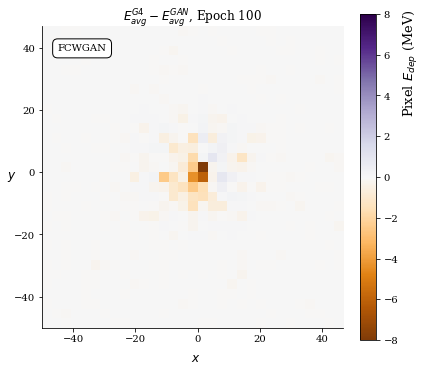

[0/100][0/938] Loss_D: -1.5220 Loss_G: 0.7986 D(x): 3.0924 D(G(z)): 1.5703 / 0.7986
[0/100][100/938] Loss_D: -0.3424 Loss_G: -7.8065 D(x): 12.6514 D(G(z)): 12.3090 / -7.8065
[0/100][200/938] Loss_D: -0.9078 Loss_G: 9.6912 D(x): -9.8315 D(G(z)): -10.7393 / 9.6912
[0/100][300/938] Loss_D: -3.0364 Loss_G: 18.4533 D(x): -12.1721 D(G(z)): -15.2085 / 18.4533
[0/100][400/938] Loss_D: 4.3169 Loss_G: -20.2151 D(x): 20.5816 D(G(z)): 24.8985 / -20.2151
[0/100][500/938] Loss_D: -4.0974 Loss_G: 2.6320 D(x): -0.3050 D(G(z)): -4.4024 / 2.6320

[0/100][600/938] Loss_D: -0.3460 Loss_G: 16.6217 D(x): -13.9998 D(G(z)): -14.3458 / 16.6217
[0/100][700/938] Loss_D: -2.9530 Loss_G: -3.8632 D(x): 7.5194 D(G(z)): 4.5664 / -3.8632
[0/100][800/938] Loss_D: -2.6837 Loss_G: -13.7982 D(x): 14.7820 D(G(z)): 12.0983 / -13.7982
[0/100][900/938] Loss_D: -0.2217 Loss_G: 20.1546 D(x): -19.3162 D(G(z)): -19.5378 / 20.1546


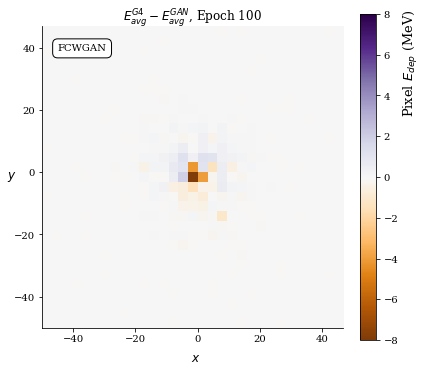

[1/100][0/938] Loss_D: 1.9566 Loss_G: 0.0493 D(x): 0.0837 D(G(z)): 2.0403 / 0.0493
[1/100][100/938] Loss_D: -2.1353 Loss_G: -39.3301 D(x): 47.5273 D(G(z)): 45.3919 / -39.3301
[1/100][200/938] Loss_D: -4.8277 Loss_G: 42.7531 D(x): -36.2981 D(G(z)): -41.1258 / 42.7531
[1/100][300/938] Loss_D: 4.8860 Loss_G: -19.6341 D(x): 20.8269 D(G(z)): 25.7129 / -19.6341
[1/100][400/938] Loss_D: -1.9357 Loss_G: 2.2845 D(x): -1.4178 D(G(z)): -3.3535 / 2.2845


Process Process-431:
Process Process-425:


[1/100][500/938] Loss_D: -1.5480 Loss_G: 8.6800 D(x): -6.3012 D(G(z)): -7.8492 / 8.6800


Process Process-430:
Process Process-427:
Process Process-429:
Process Process-428:
Traceback (most recent call last):
Traceback (most recent call last):
Process Process-432:
Exception NameError: "global name 'FileNotFoundError' is not defined" in <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f43440cd610>> ignored
Process Process-426:
Traceback (most recent call last):
  File "/home/chris/anaconda2/envs/pytorch04/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
Traceback (most recent call last):
  File "/home/chris/anaconda2/envs/pytorch04/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
Traceback (most recent call last):
Traceback (most recent call last):


KeyboardInterrupt: 

  File "/home/chris/anaconda2/envs/pytorch04/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
Traceback (most recent call last):
  File "/home/chris/anaconda2/envs/pytorch04/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
Traceback (most recent call last):
  File "/home/chris/anaconda2/envs/pytorch04/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
  File "/home/chris/anaconda2/envs/pytorch04/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
    self.run()
  File "/home/chris/anaconda2/envs/pytorch04/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
    self.run()
  File "/home/chris/anaconda2/envs/pytorch04/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
    self.run()
    self.run()
    self.run()
    self.run()
  File "/home/chris/anaconda2/envs/pytorch04/lib/python2.7/multiprocessing/process.py", line 114, in run
  File "/home/chris/anaconda2/envs/pytorch04/lib/python2.7/mult

In [15]:
iter_range = range(niter)
iter_range = tqdm(iter_range)


#make save directory
mydir = os.path.join('/home/chris/Dropbox/ForViewing/plots/Geant4/SingleLayerEGun/DCWGAN/FC', 
                    datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S') + "/")
#mydir=None
print(mydir)
if mydir != None:
    try:
        os.makedirs(mydir)
    except OSError as e:
        if e.errno != errno.EEXIST:
            raise
            
    with open(mydir + 'NetworkInfo.txt', 'w') as f:
        f.write( 'generator: ' +  str(netG) + "\n")
        f.write('discriminator: ' +  str(netD) + '\n')
        f.write('normalization scale: ' +  norm_scale + '\n')
        f.write('image height/width: ' + str(imageSize) + '\n')
        f.write('loss function: BCE with Roth Penalty \n')

extraD = 1
gamma=0.1
        
for epoch in iter_range:
    if True:       
        data, n_events = make_samples(netG, n_events = 1000, scale =scale, norm_scale=norm_scale)
        real_data_array, fake_data_array = make_stacked_samples(netG, n_events = 1000,real= True, fake = True, 
                                                                scale = scale, norm_scale = norm_scale)
        #print(data[1].shape)
        #print(data[1].shape)
        #genx_FWHM = hist_width(np.sum(data[1],1))
        #realx_FWHM = hist_width(np.sum(data[0],1))
        #genx_mean = np.sum(data[1],1).mean()
        #print genx_mean
        #realx_mean = np.sum(data[0],1).mean()
        #genx_FWHMs.append(genx_FWHM)
        #realx_FWHMs.append(realx_FWHM)
        #genx_means.append(genx_mean)
        #realx_means.append(realx_mean)
        epochs.append(epoch)
        #plot_all_metrics(genx_FWHMs, realx_FWHMs, genx_means, realx_means,epochs = epochs, save_dir = mydir)
        #plot_sns(n_events, save_dir=mydir,  epoch = epoch)
#         plot_avg_both(data[0],data[1], n_events, save_dir = mydir,  epoch = epoch)
#         plot_avg(data[1], n_events, save_dir= mydir,  epoch = epoch)
#         plot_many(fake_data_array, rows=2, columns=7, real=False, save_dir=mydir, epoch=epoch)
#         xsection_multi(data, epoch, savedir=mydir, imageSize=imageSize)
#         if epoch > 0:
#             stats_r, stats_f = calc_means_stds(imageSize=imageSize, n_times = 10)
#             plot_means_stds(stats_r, stats_f, save_dir = mydir, trim = 10)
        #plot_many(fake_data_array, real=False, save_dir=mydir, epoch = epoch)
        #plot_many(real_data_array, real=True, save_dir=mydir, epoch = epoch)
        if epoch % 1 == 0:
            plot_difference(data, save_dir = mydir, epoch = 100, n_events = 1000)
    for i, data in enumerate(dataloader,0):
        for j in range(extraD):
            ############################
#             # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z))), do it more than generator
#             ###########################
#             # train with real
#             netD.zero_grad()
#             real_cpu = data[0].to(device).requires_grad_().view(-1,imageSize*imageSize)
#             #print(real_cpu.shape)
#             batch_size = real_cpu.size(0)
#             label_r = torch.full((batch_size,), real_label, device=device)
#             #real_cpu.requires_grad_()
#             output_r = netD(real_cpu)
#             #real_cpu.requires_grad_()
#             #output_r.sum().requires_grad_()
#             errD_real = criterion(output_r, label_r)
#             #errD_real.backward()
#             D_x = output_r.mean().item()
            
            
            #penalty = grad(output_r.sum(), real_cpu, create_graph=True)[0].view(-1,1).norm(2,1).pow(2).mean()
            #(errD_real + (gamma/2) * penalty).backward()
            #print(penalty)


#             # train with fake
#             noise = torch.randn(batch_size, nz, device=device)
#             fake = netG(noise)
#             label_f = torch.full((batch_size,), fake_label, device=device)
#             #label.fill_(fake_label)
#             output_f = netD(fake.detach())
#             errD_fake = criterion(output_f, label_f)
#             errD_fake.backward()
#             D_G_z1 = output_f.mean().item()
#             errD = errD_real + errD_fake
#             #(errD + (gamma/2) * penalty).backward()
#             optimizerD.step()
            
            
            
            for p in netD.parameters():  # reset requires_grad
                p.requires_grad = True  # they are set to False below in netG update
                
            netD.zero_grad()
            #real_cpu = data[0].to(device)
            real_cpu = data[0].to(device).requires_grad_().view(-1,imageSize*imageSize)
            batch_size = real_cpu.size(0)
           # label = torch.full((batch_size,), real_label, device=device)

            output_Dr = netD(real_cpu)
            real_cpu.requires_grad_()
            #errD_real = criterion(output, label)
            D_x = output_Dr.mean()
            errD_real = D_x
            #errD_real.backward((torch.FloatTensor([1]) * -1).cuda(1))
            
            #D_x = output.mean()

            # train with fake
            noise = torch.randn(batch_size, nz, device=device)
            fake = netG(noise)
            #label.fill_(fake_label)
            output_Df = netD(fake.detach())

            #errD_fake.backward()
            D_G_z1 = output_Df.mean()
            #errD = errD_real + errD_fake
            errD_fake = D_G_z1
            #errD_fake.backward((torch.FloatTensor([1])).cuda(1))

            errD = -errD_real + errD_fake
            #gradD = grad(errD, fake, create_graph=True, allow_unused=True)[0]
            
            #improved training of wasserstein gans
            #reguD = gradD.norm(2, 1).clamp(1).mean()

            lamD = 25.
            #print(real_cpu.reshape(batch_size,1, 32,32).shape)
            gp = gradient_penalty(real_cpu.reshape(batch_size,1, imageSize,imageSize), fake.reshape(batch_size,1, imageSize,imageSize), lamda=lamD)
            (errD + gp).backward()
            #errD.backward()
            optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        for p in netD.parameters():
            p.requires_grad = False  # to avoid computation
        netG.zero_grad()
      #  label.fill_(real_label)  # fake labels are real for generator cost
        output_G = netD(fake)
        #errG = criterion(output, label)
        D_G_z2 = -1*output_G.mean() 
        #errG.backward((torch.FloatTensor([1]) * -1).cuda(1))
        errG = D_G_z2
        errG.backward(retain_graph=True)
        #D_G_z2 = output.mean().item()
        optimizerG.step()

        if i % 100 == 0:
            print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f'
                  % (epoch, niter, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
#         if i % 500 == 0:
#             vutils.save_image(real_cpu.data,
#                     '%s/real_samples.png' % outf,
#                     normalize=True)
#             fake = netG(fixed_noise)
#             vutils.save_image(fake.detach(),
#                     '%s/fake_samples_epoch_%03d.png' % (outf, epoch),
#                    normalize=True)

In [ ]:
#FAKE
#from mpl_toolkits.axes_grid1 import make_axes_locatable



data, n_events = make_samples(netG,n_events = 1000, real=True, fake=True)

#data_diff = data_test[0] - data_test[1]
plot_avg(data[1], n_events = 1000, save_dir=None)


/home/chris/anaconda2/envs/pytorch04/lib/python2.7/site-packages/ipykernel_launcher.py:734: RuntimeWarning: invalid value encountered in sqrt


(32,)


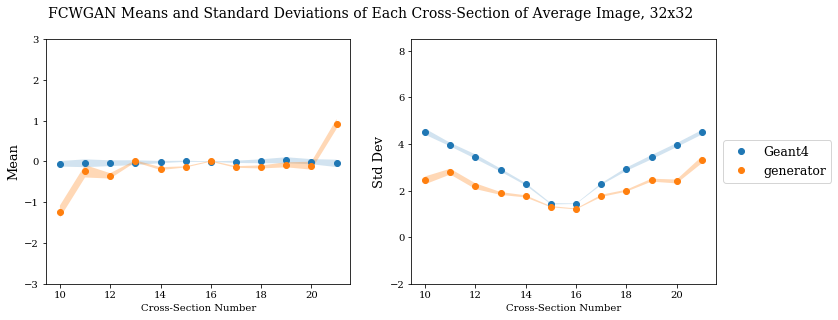

In [156]:
# mydir = os.path.join('/home/chris/Documents/MPhilProjects/ForViewing/plots/Geant4/SingleLayerEGun/DCROTHGAN/', 
#                      datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S') + "/")
# #mydir=None
# print(mydir)
# try:
#     os.makedirs(mydir)
# except OSError as e:
#     if e.errno != errno.EEXIST:
#         raise
        

#plot_sns(save_dir = None)
#real_data_array, fake_data_array = make_stacked_samples(netG, n_events = 1000,real= True, fake = True)
#plot_many(fake_data_array, rows=2, columns=7, real=False, save_dir=mydir, epoch=epoch)
stats_r, stats_f = calc_means_stds(imageSize=imageSize, n_times = 10)
plot_means_stds(stats_r, stats_f, save_dir = mydir, trim = 10)
#data, n_events = make_samples(netG, n_events = 1000, scale =scale, norm_scale=norm_scale)
#plot_difference(data, save_dir = mydir, epoch = 100, n_events = 1001)
#xsection_multi(data, epoch, savedir=mydir, imageSize=imageSize)

In [54]:
test = np.squeeze(image_array)
for i in range(test.shape[0]):
    if np.isnan(test[i].max()) ==True:
        print(i)

In [ ]:
#REAL
plt.rc('font', family='serif')
many_samples = True
n_events = 5000
#make single samples for both real and fake. then make many samples and average if many_samples = True

#real
idx = np.random.randint(low = 0, high = image_array.shape[0], size =1)[0]
real_image = image_array[idx][0]

#fake
noise = torch.randn(batch_size, nz, 1, 1, device=device)
fake = netG(noise)
fake_image = fake.to('cpu').detach().numpy()[0][0]
test_unnormed =  arctanh_unnormalize(fake_image, scale)

if many_samples == True:
    for i in range(n_events):
        idx = np.random.randint(low = 0, high = image_array.shape[0], size =1)[0]
        real_image += image_array[idx][0]
        noise = torch.randn(batch_size, nz, 1, 1, device=device)
        fake = netG(noise)
        fake_image = fake.to('cpu').detach().numpy()[0][0]
        test_unnormed +=  arctanh_unnormalize(fake_image, scale)

real_image = real_image / n_events
test_unnormed = test_unnormed / n_events
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(9, 6), sharex=True, sharey=True)
xran = (-50,50)
yran = (-50,50)
extent = xran + yran





real_image[real_image < 0.0] = np.nan
cmap = sns.cubehelix_palette(dark = 0.4, light=0.915, gamma = 2.5, hue = 1, start =0, as_cmap=True)
#plt.hist2d(fake.to('cpu').detach().numpy()[0][0][:,0], fake.to('cpu').detach().numpy()[0][0][:,1])
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

ax2.spines['top'].set_visible(False)
ax2.spines['left'].set_visible(False)
im = ax1.imshow(real_image, vmin = 0, extent=extent, origin='lower', cmap=cmap)




ax1.set_title("Real")
#cbar = plt.colorbar(im, fraction=0.05, pad=0.05)
#cbar.set_label(r'Pixel $E_{dep}$ (MeV)', y=0.85)
        
test_unnormed[test_unnormed < 0.0] = np.nan
im = ax2.imshow(test_unnormed, vmin = 0, extent=extent, origin='lower', cmap=cmap)
ax2.set_title("Generator")

fig.tight_layout(rect=[0, 0, .9, 1])
cbar_ax = fig.add_axes([0.9, 0.25, 0.025, 0.5])
cb = fig.colorbar(im, cax=cbar_ax)
cb.set_label(r'$E_{dep}$ (MeV)', y =0.85)
fig.subplots_adjust(wspace=0.1, hspace=0)
fig.suptitle(r" DCROTHGAN Avg $E_{dep}$ Over " + str(n_events) + " Events, "
             + str(imageSize) + "x" +str(imageSize) + " Image Size, " + str(niter) 
             + " Epochs, " + str(batchSize) + " Batch Size", x = 0.5, y = 0.9)
plt.show()

In [412]:
mydir = os.path.join('/home/chris/Documents/MPhilProjects/ForViewing/plots/Geant4/SingleLayerEGun/DCROTHGAN/', 
                     datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S') + '/')
print(mydir)
try:
    os.makedirs(mydir)
except OSError as e:
    if e.errno != errno.EEXIST:
        raise

/home/chris/Documents/MPhilProjects/ForViewing/plots/Geant4/SingleLayerEGun/DCGAN/2018-05-16_17-09-05/


In [293]:
data_test, n_events = make_samples(netG,n_events = 10000, real=True, fake=True)
mydir = "/home/chris/Documents/MPhilProjects/ForViewing/plots/Geant4/SingleLayerEGun/DCROTHGAN/2018-05-18_18-39-35/"

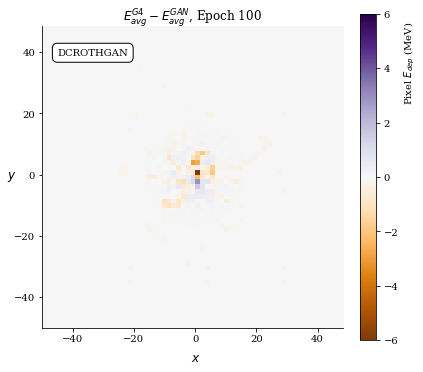

In [320]:

def plot_difference(real_fake_list, n_events = 500, save_dir = None, epoch = epoch, batchSize=batchSize, imageSize=imageSize, lr=lr, norm_scale = norm_scale):
#mean_normalizer = data_test[1][data_test[1] > 0.0].max()
    data = (real_fake_list[0] - real_fake_list[1]) 
#plot_avg(data_diff, n_events = 5000, save_dir=None)
    test_noNans = np.copy(data)
    test_unnormed = data
#test_unnormed[test_unnormed < ] = np.nan

    xran = (-50,50)
    yran = (-50,50)
    extent = xran + yran
    #cmap = sns.cubehelix_palette(dark = 0.4, light=0.93, gamma = 2.5, hue = 1, start =2, as_cmap=True)
    #cmap = sns.light_palette((210, 95, 30), input='husl', as_cmap=True)
    #cmap = sns.color_palette("BrBG", 7, as_cmap=True)
    cmap = sns.diverging_palette(30, 270, s=80, l=55, n=11, as_cmap = True)
    color_list = sns.cubehelix_palette(dark=0.4, light=0.93, gamma=2.5, hue=1).as_hex()


    fig, ax=plt.subplots(figsize=(6, 6))
    #plt.hist2d(fake.to('cpu').detach().numpy()[0][0][:,0], fake.to('cpu').detach().numpy()[0][0][:,1])
    im = ax.imshow(test_unnormed, vmin = -6,vmax = 6, extent=extent, origin='lower', cmap='PuOr', label ='DCROTHGAN')
    cbar = plt.colorbar(im, fraction=0.05, pad=0.05)
    cbar.set_label(r'Pixel $E_{dep}$ (MeV)', y=0.85)
    plt.title(r"$E_{avg}^{G4} - E_{avg}^{GAN}$, Epoch " + str(epoch))
    ax.text(-45, 39, 'DCROTHGAN', color='black', 
        bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
    #plt.legend(loc = 'best')
    ax.set_xlim(tlim)
    ax.set_xlabel(r"$\mathit{x}$", fontsize = 12)
    ax.xaxis.set_label_coords(0.51,-0.08)
    ax.set_ylim(tlim)
    ax.set_ylabel(r"$\mathit{y}$", fontsize = 12, rotation = 0)
    ax.yaxis.set_label_coords(-.1,0.48)
    ax.spines["top"].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    
    if save_dir != None:
        learning_rate = '%.0E' % Decimal(lr)
        #directory = "/home/chris/Documents/MPhilProjects/ForViewing/plots/Geant4/SingleLayerEGun/DCROTHGAN/"
        filename = "DCROTHGAN_EdepDifference"+str(marginals_str) + "Over" + str(n_events) + "Events_" + str(imageSize) + "x" +str(imageSize) \
                    + "Image_Epoch" + str(epoch) + "_" + norm_scale + "Normalized_" + str(batchSize) + "batchSize_" +  str(learning_rate) + "lr.png"
        plt.savefig(save_dir + filename, bbox_inches='tight')

    plt.show()
    return

plot_difference(data_test, save_dir = mydir, epoch = 100)


In [ ]:

def plot_difference(real_fake_list, n_events = 500, save_dir = None, epoch = epoch, batchSize=batchSize, imageSize=imageSize, lr=lr, norm_scale = norm_scale)
#mean_normalizer = data_test[1][data_test[1] > 0.0].max()
data = (real_fake_list[0] - real_fake_list[1]) 
#plot_avg(data_diff, n_events = 5000, save_dir=None)
withMarginals = False
save_dir = mydir
test_noNans = np.copy(data)
test_unnormed = data
#test_unnormed[test_unnormed < ] = np.nan

xran = (-50,50)
yran = (-50,50)
extent = xran + yran
#cmap = sns.cubehelix_palette(dark = 0.4, light=0.93, gamma = 2.5, hue = 1, start =2, as_cmap=True)
#cmap = sns.light_palette((210, 95, 30), input='husl', as_cmap=True)
#cmap = sns.color_palette("BrBG", 7, as_cmap=True)
cmap = sns.diverging_palette(30, 270, s=80, l=55, n=11, as_cmap = True)
color_list = sns.cubehelix_palette(dark=0.4, light=0.93, gamma=2.5, hue=1).as_hex()

if withMarginals == False:
    fig, ax=plt.subplots(figsize=(6, 6))
    #plt.hist2d(fake.to('cpu').detach().numpy()[0][0][:,0], fake.to('cpu').detach().numpy()[0][0][:,1])
    im = ax.imshow(test_unnormed, vmin = -6,vmax = 6, extent=extent, origin='lower', cmap='PuOr')
    cbar = plt.colorbar(im, fraction=0.05, pad=0.05)
    cbar.set_label(r'Pixel $E_{dep}$ (MeV)', y=0.85)
    plt.title("DCROTHGAN Difference between average Geant4 \n Image and Average Generator Image")
    if save_dir != None:
        learning_rate = '%.0E' % Decimal(lr)
        #directory = "/home/chris/Documents/MPhilProjects/ForViewing/plots/Geant4/SingleLayerEGun/DCROTHGAN/"
        filename = "DCROTHGAN_EdepDifference"+str(marginals_str) + "Over" + str(n_events) + "Events_" + str(imageSize) + "x" +str(imageSize) \
                    + "Image_Epoch" + str(epoch) + "_" + norm_scale + "Normalized_" + str(batchSize) + "batchSize_" +  str(learning_rate) + "lr.png"
        plt.savefig(save_dir + filename, bbox_inches='tight')

else:
    fig=plt.figure(figsize=(6, 6))
    marginals_str = 'withMarginals'
    img=test_noNans
    t = np.arange(-50,50, 100/float(imageSize))
    #t = np.arange(img.shape[0])
    f = np.arange(-50,50, 100/float(imageSize))
    #f = np.arange(img.shape[1])
    flim = (f.min(), f.max())
    tlim = (t.min(), t.max())

    gs = gridspec.GridSpec(2, 2, width_ratios=[1,5], height_ratios=[1,5])
    gs.update(hspace=0, wspace=0)

    ax = fig.add_subplot(gs[1,1])
    im = ax.imshow(test_unnormed, vmin = -10, vmax = 10, extent = extent, origin = 'lower', cmap = 'PuOr')
    cbaxes = fig.add_axes([0.97, 0.18, 0.03, 0.55]) 
    cbar = plt.colorbar(mappable=im, ticks = None, cax=cbaxes, use_gridspec=True)
    ax.yaxis.set_ticks_position('right')
    cbar.set_label(r'Pixel $E_{dep}$ (MeV)', y=0.85)
    ax.spines["top"].set_visible(False)
    ax.spines['left'].set_visible(False)

    axl = fig.add_subplot(gs[1,0], sharey=ax)
    axl.fill_between(img.mean(1), f, alpha = 0.7, color = color_list[1])
    axl.invert_xaxis()
    axb = fig.add_subplot(gs[0,1], sharex=ax)
    axb.fill_between(t, img.mean(0), alpha =0.7, color= color_list[1])

    plt.setp(axl.get_yticklabels(), visible=False)
    plt.setp(axb.get_xticklabels(), visible=False)
    plt.setp(axl.get_xticklabels(), visible=False)
    plt.setp(axb.get_yticklabels(), visible=False)

    axl.yaxis.set_ticks_position('none')
    axb.xaxis.set_ticks_position('none')
    axl.xaxis.set_ticks_position('none')
    axb.yaxis.set_ticks_position('none')


    axl.spines["top"].set_visible(False)
    axl.spines['right'].set_visible(False)
    axl.spines['left'].set_visible(False)
    axl.spines['bottom'].set_visible(False)
    axb.spines["top"].set_visible(False)
    axb.spines["right"].set_visible(False)
    axb.spines["left"].set_visible(False)
    axb.spines["bottom"].set_visible(False)
    ax.set_xlim(tlim)
    ax.set_xlabel(r"$\mathit{x}$", fontsize = 12)
    ax.xaxis.set_label_coords(0.02,-0.05)
    ax.set_ylim(tlim)
    ax.set_ylabel(r"$\mathit{y}$", fontsize = 12, rotation = 0)
    ax.yaxis.set_label_coords(1.07,0.98)
    plt.title("DCROTHGAN Difference between average Geant4 Image \n and Average Generator Image")
    if save_dir != None:
        learning_rate = '%.0E' % Decimal(lr)
        #directory = "/home/chris/Documents/MPhilProjects/ForViewing/plots/Geant4/SingleLayerEGun/DCROTHGAN/"
        filename = "DCROTHGAN_EdepDifference"+str(marginals_str) + "Over" + str(n_events) + "Events_" + str(imageSize) + "x" +str(imageSize) \
                    + "Image_Epoch" + str(epoch) + "_" + norm_scale + "Normalized_" + str(batchSize) + "batchSize_" +  str(learning_rate) + "lr.png"
        plt.savefig(save_dir + filename, bbox_inches='tight')
    plt.show()


/home/chris/anaconda2/envs/pytorch04/lib/python2.7/site-packages/ipykernel_launcher.py:343: RuntimeWarning: invalid value encountered in less_equal


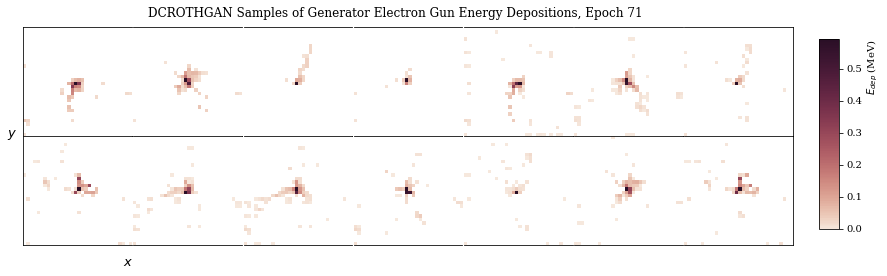

In [123]:
# def plot_many(data, rows = 1,columns = 4, real = True, save_dir = None, epoch = epoch, batchSize=batchSize, imageSize=imageSize, lr=lr, norm_scale = norm_scale):
    
#     xran = (-50,50)
#     yran = (-50,50)
#     extent = xran + yran
    
#     if rows <= 2 and columns <=4:
#         scale_factor = 3.5
#     else:
#         scale_factor = 2
    
#     fig, axes =plt.subplots(rows,columns, figsize=(scale_factor*columns, scale_factor*rows), sharex=True,sharey=True)
#     #print(len(axes))
#     event_number = 0
#     plt.locator_params(axis='y', nbins=1)
#     plt.locator_params(axis='x', nbins=2)
#     #fig.xticks(rotation=45)
#     for i in range(rows):
#         for j in range(columns):

#             #print(range(rows))
#             image_array = data[event_number]

#             image_array[image_array < 0.01] = np.nan
#             cmap = sns.cubehelix_palette(dark = 0.4, light=0.965, gamma = 2.5, hue = 1, start =0, as_cmap=True)
#             #cmap = sns.light_palette((210, 95, 30), input='husl', as_cmap=True)
#             #cmap = sns.dark_palette('muted purple', as_cmap=True, input='xkcd')
#             #cmap = sns.color_palette("BrBG",7)
#             #img = ax.imshow(image_array[0], vmin = 0, extent=extent, origin='lower', cmap=cmap)
#             #axes[i,j].set_aspect('equal')
#             plt.axis('on')
#             if rows == 1:
#                 #axes[j] = plt.subplot(gs1[i,j])
#                 if j != 0:
#                     axes[j].spines['left'].set_visible(False)
#                 else:
#                     axes[j].set_xlabel(r"$\mathit{x}$", fontsize=13, x = 0.96)
#                     axes[j].set_ylabel(r"$\mathit{y}$", fontsize=13, rotation=0, y = .95)
#                 axes[j].spines['top'].set_visible(False)
#                 axes[j].spines['right'].set_visible(False)
#                 #axes[j].spines['bottom'].set_visible(False)
#                 #axes[j].spines['left'].set_visible(False)
#                 #axes[j].set_aspect('equal')
#                 im =axes[j].imshow(image_array, vmin = 0, extent=extent, origin='lower', cmap=cmap)
#                 #axes[i,j].set_xticklabels([-100,0,100],rotation=90)
#                 axes[j].set_xticklabels([])
#                 axes[j].set_yticklabels([])
#                 axes[j].xaxis.set_ticks_position('none')
#                 axes[j].yaxis.set_ticks_position('none')
#                 event_number +=1
#             else:
#                 #axes[i,j].spines['top'].set_visible(False)
#                 axes[i,j].spines['bottom'].set_visible(True)
#                 if j!= 0:
#                     axes[i,j].spines['left'].set_visible(False)
#                 if i == range(rows)[-1] and j == 0:
#                     axes[i,j].set_xlabel(r"$\mathit{x}$", fontsize=13, x = 0.96)
#                     axes[i,j].set_ylabel(r"$\mathit{y}$", fontsize=13, rotation=0, y = .95)
                    
#                 if j == range(columns)[-1]:
#                     axes[i,j].spines['right'].set_visible(True)
#                 else:
#                     axes[i,j].spines['right'].set_visible(False)
#                 im =axes[i,j].imshow(image_array, vmin = 0,  extent=extent, origin='lower', cmap=cmap)
#                 #axes[i,j].set_xticklabels([-100,0,100],rotation=90)
#                 axes[i,j].set_xticklabels([])
#                 axes[i,j].set_yticklabels([])
#                 axes[i,j].xaxis.set_ticks_position('none')
#                 axes[i,j].yaxis.set_ticks_position('none')
#                 event_number +=1
#     #fig.tight_layout(rect=[0, 0, .9, 1])
#     cbar_ax = fig.add_axes([0.92, 0.18, 0.02, 0.66])
#    # fig.text(0.5,0.04, "Some very long and even longer xlabel", ha="center", va="center")
#     #fig.text(0.05,0.5, "Some quite extensive ylabel", ha="center", va="center", rotation=90)

#     cb = fig.colorbar(im, cax=cbar_ax)
#     cb.set_label(r'$E_{dep}$ (MeV)', y =0.85)
#     #plt.tight_layout()
#     fig.subplots_adjust(wspace=-0.085, hspace=0.00)
#     if real == True:
#         fig.suptitle("Samples of Geant4 Electron Gun Energy Depositions", y = 0.95)
#     else:
#         fig.suptitle("DCROTHGAN Samples of Generator Electron Gun Energy Depositions, Epoch " + str(epoch), y=0.95)
    
#     num_samples = rows *columns
        
        
#     if save_dir != None:
#         if real == True:
#             type_string = "real"
#         else:
#             type_string = "fake"
        
#         learning_rate = '%.0E' % Decimal(lr)
#         #directory = "/home/chris/Documents/MPhilProjects/ForViewing/plots/Geant4/SingleLayerEGun/DCROTHGAN/"
#         filename = "DCROTHGAN_"+str(num_samples) + type_string+ "SamplesEdepOver" + str(n_events) + "Events_" + str(imageSize) + "x" +str(imageSize) \
#                             + "Image_Epoch" + str(epoch) + "_" + norm_scale + "Normalized_" + str(batchSize) + "batchSize_" +  str(learning_rate) + "lr"
#         #print(save_dir)
#         plt.savefig(save_dir + filename, bbox_inches='tight')
    
        
#     plt.show()
#     return



plot_many(fake_data_array, rows=2, columns=7, real=False, save_dir=mydir, epoch=epoch, norm_scale=norm_scale)

2.0272846


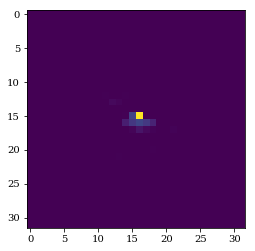

In [141]:
noise = torch.randn(batchSize, nz, 1, 1, device=device)
fake_output = netG(noise)
gen_image = fake_output.to('cpu').detach().numpy()[0][0]
print(gen_image.max())
plt.imshow(gen_image)

#data, n_events = make_samples(netG, n_events = 1000)
#real_data_array, fake_data_array = make_stacked_samples(netG, n_events = 1000,real= True, fake = True)

In [47]:
fake_data_array.max()

9.704778